# RNN Debug

The code is from the pytorch official example. Please feel free to change the training strategies (learning rate, optimizer, and LR policy) as we mentioned in T11 slides.


In [12]:
import numpy as np
import torch
import argparse
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib
import matplotlib.pyplot as plt


In [13]:
# Generate samples
np.random.seed(2)

T = 20
L = 1000
N = 100

x = np.empty((N, L), 'int64')
x[:] = np.array(range(L)) + np.random.randint(-4 * T, 4 * T, N).reshape(N, 1)
data = np.sin(x / 1.0 / T).astype('float64')
torch.save(data, open('traindata.pt', 'wb'))

In [9]:
# define a RNN model
class Sequence(nn.Module):
    def __init__(self):
        super(Sequence, self).__init__()
        self.lstm1 = nn.LSTMCell(1, 51)
        self.lstm2 = nn.LSTMCell(51, 51)
        self.linear = nn.Linear(51, 1)

    def forward(self, input, future = 0):
        outputs = []
        h_t = torch.zeros(input.size(0), 51, dtype=torch.double)
        c_t = torch.zeros(input.size(0), 51, dtype=torch.double)
        h_t2 = torch.zeros(input.size(0), 51, dtype=torch.double)
        c_t2 = torch.zeros(input.size(0), 51, dtype=torch.double)

        for input_t in input.split(1, dim=1):
            h_t, c_t = self.lstm1(input_t, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs += [output]
        for i in range(future):# if we should predict the future
            h_t, c_t = self.lstm1(output, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs += [output]
        outputs = torch.cat(outputs, dim=1)
        return outputs

STEP:  0
loss: 0.5023738120466186
test loss: 0.49494166856950317


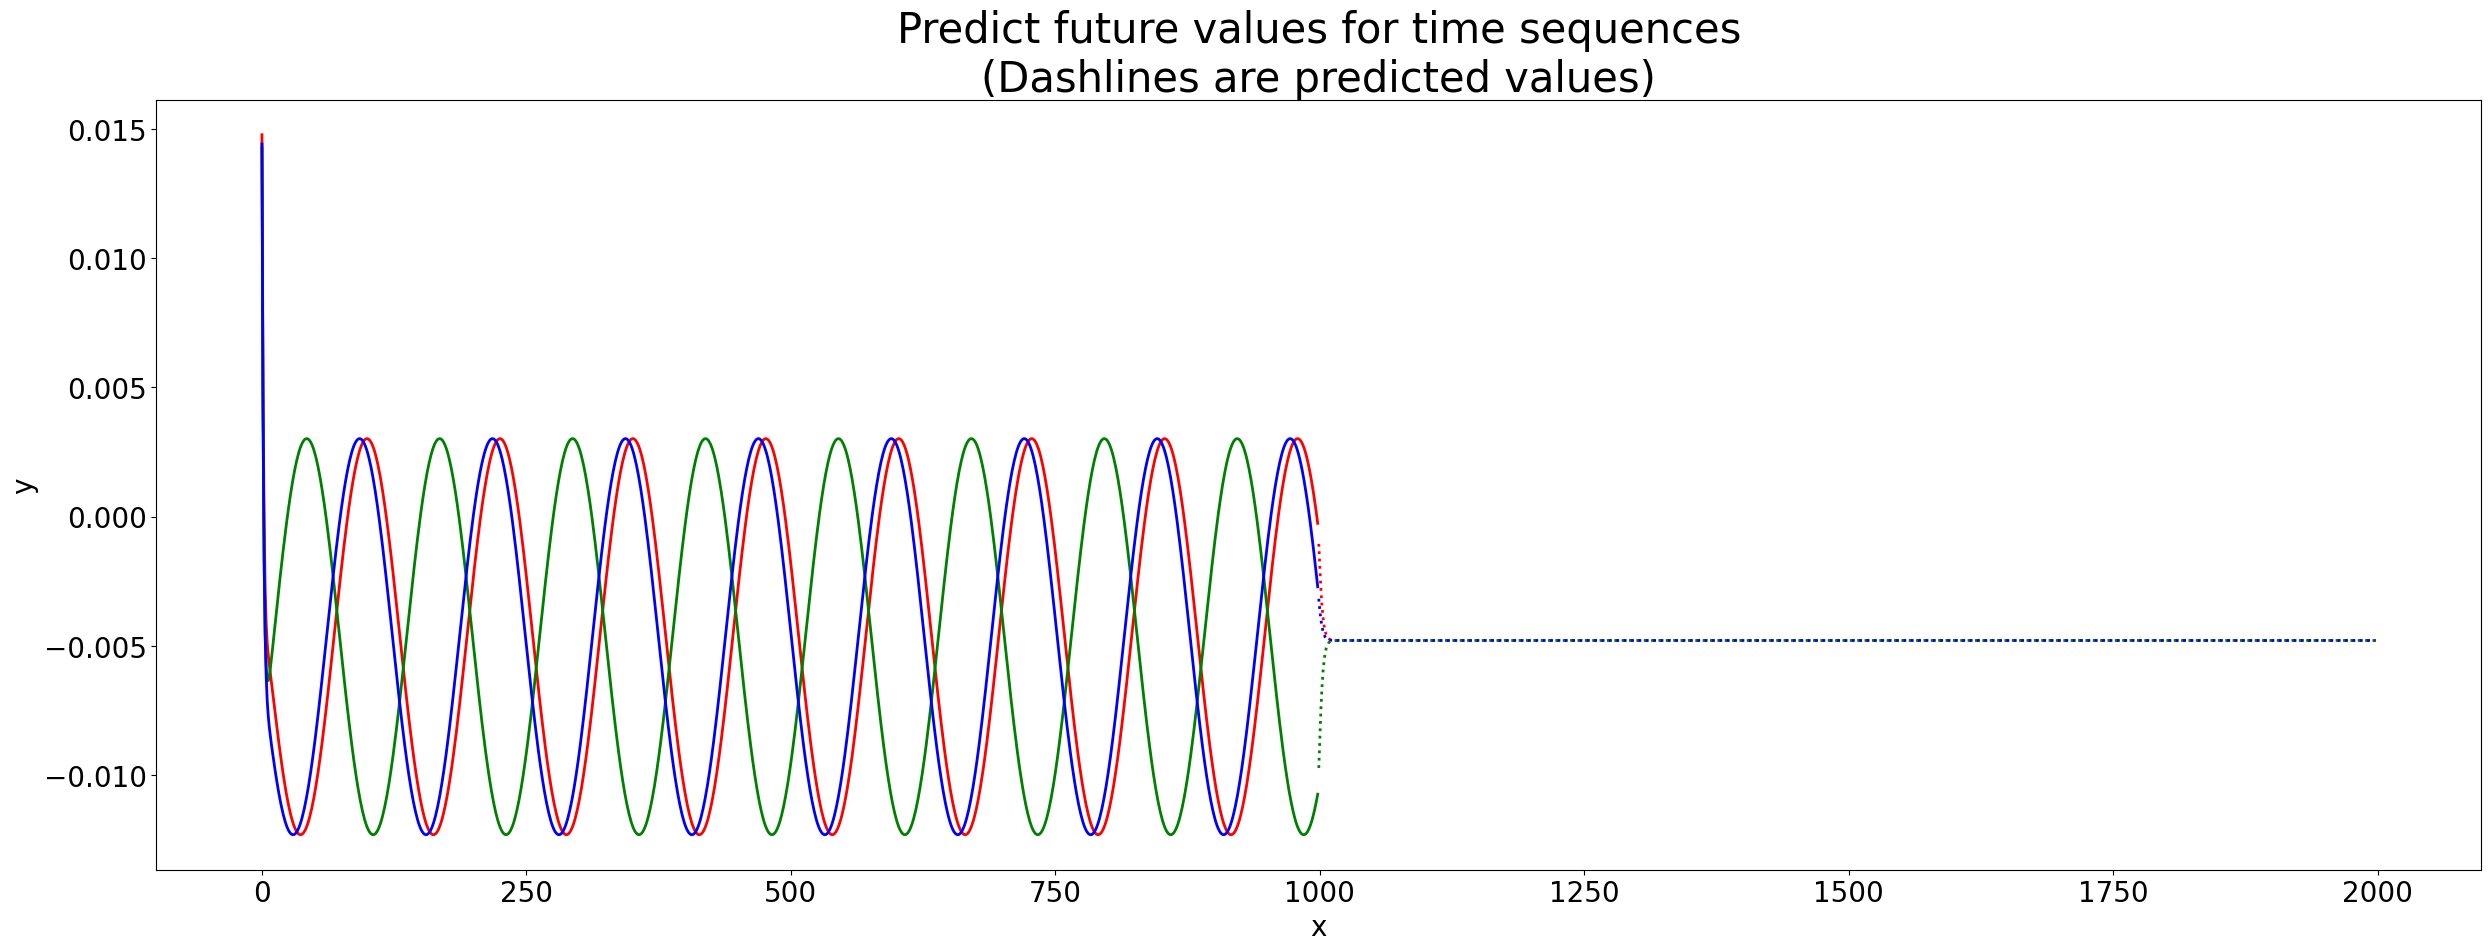

STEP:  1
loss: 0.49266771102360024
test loss: 0.48777044942365416


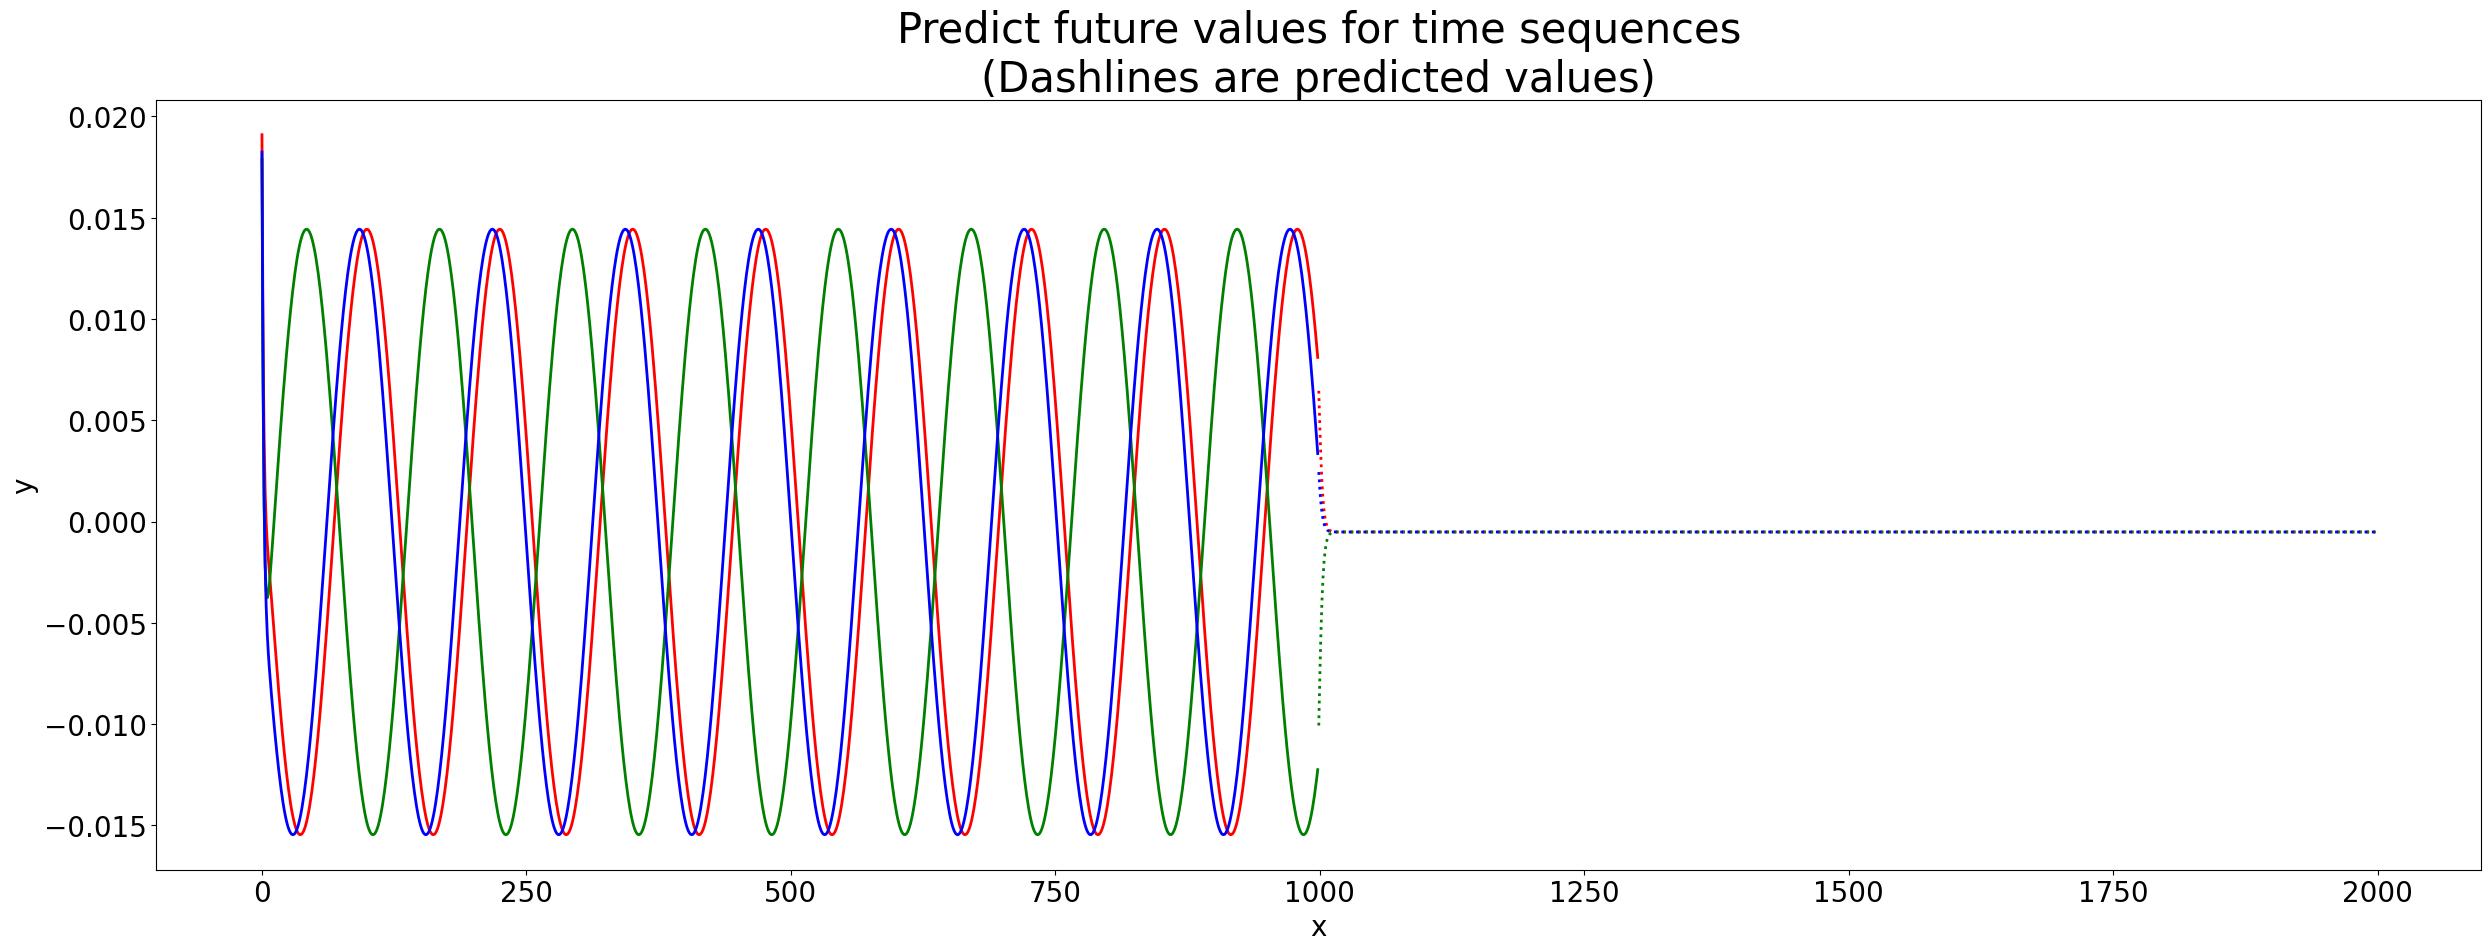

STEP:  2
loss: 0.48554108842069915
test loss: 0.4797718830072589


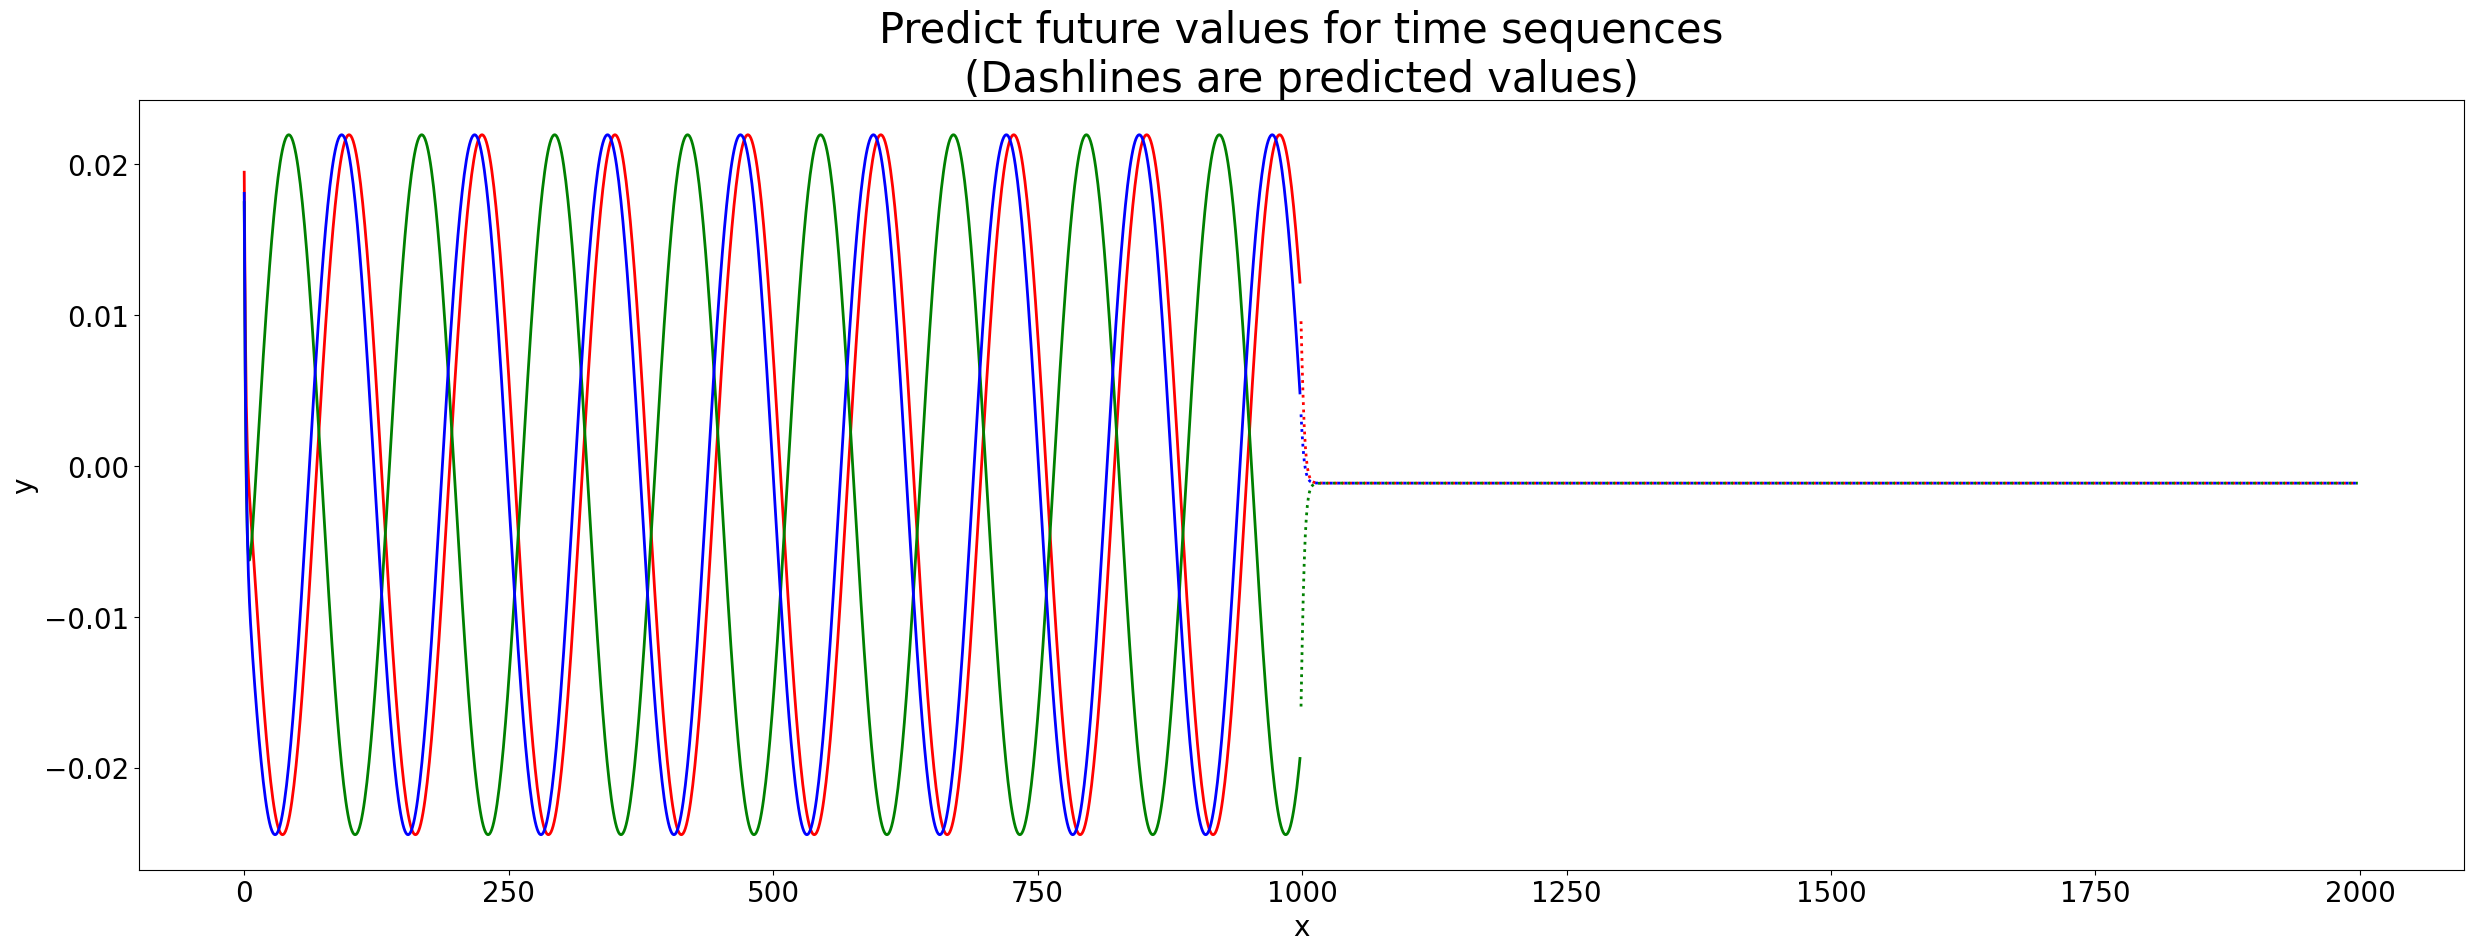

STEP:  3
loss: 0.47759346611915776
test loss: 0.4702974825437689


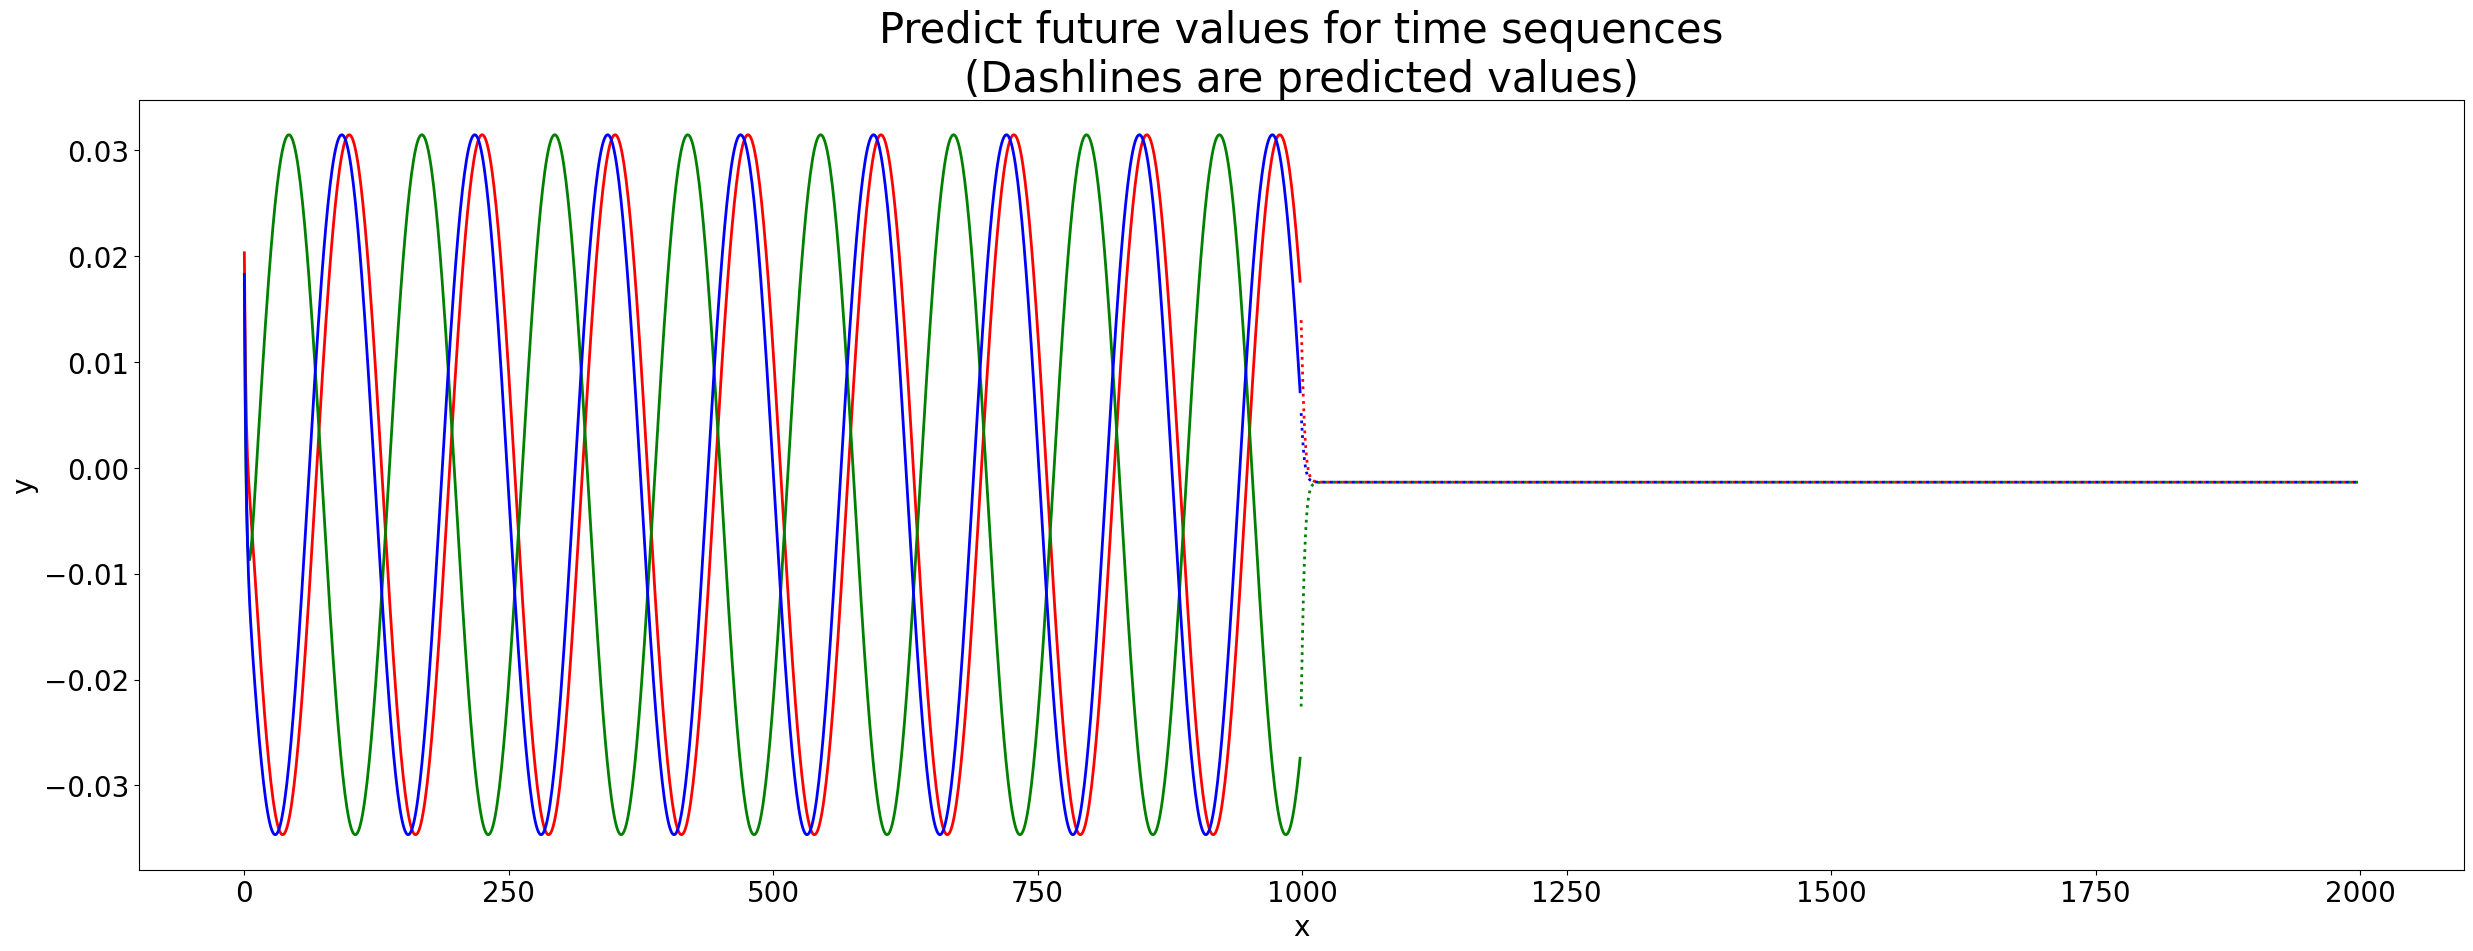

STEP:  4
loss: 0.46817988180639275
test loss: 0.45850805586000587


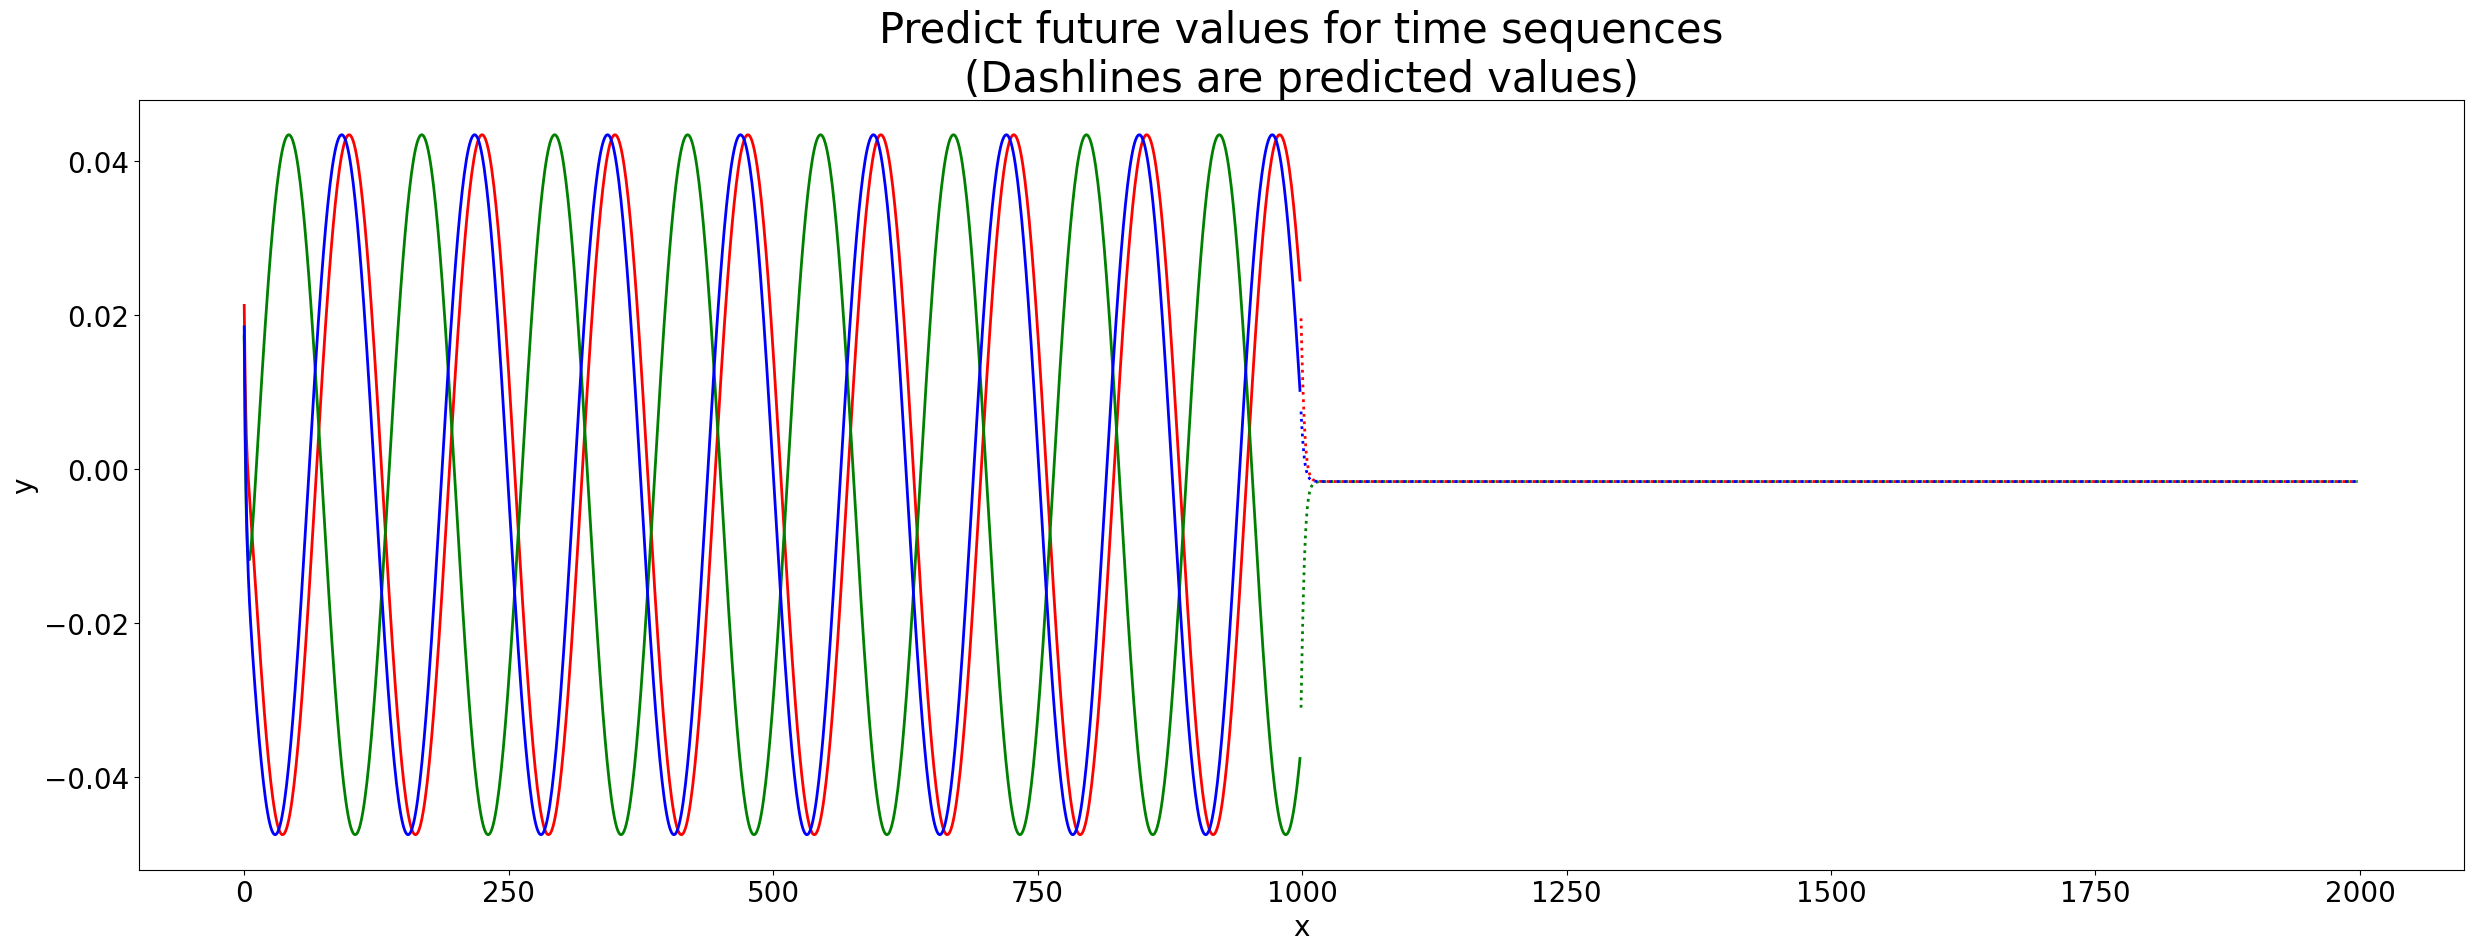

STEP:  5
loss: 0.45646692824034096
test loss: 0.4432099108578947


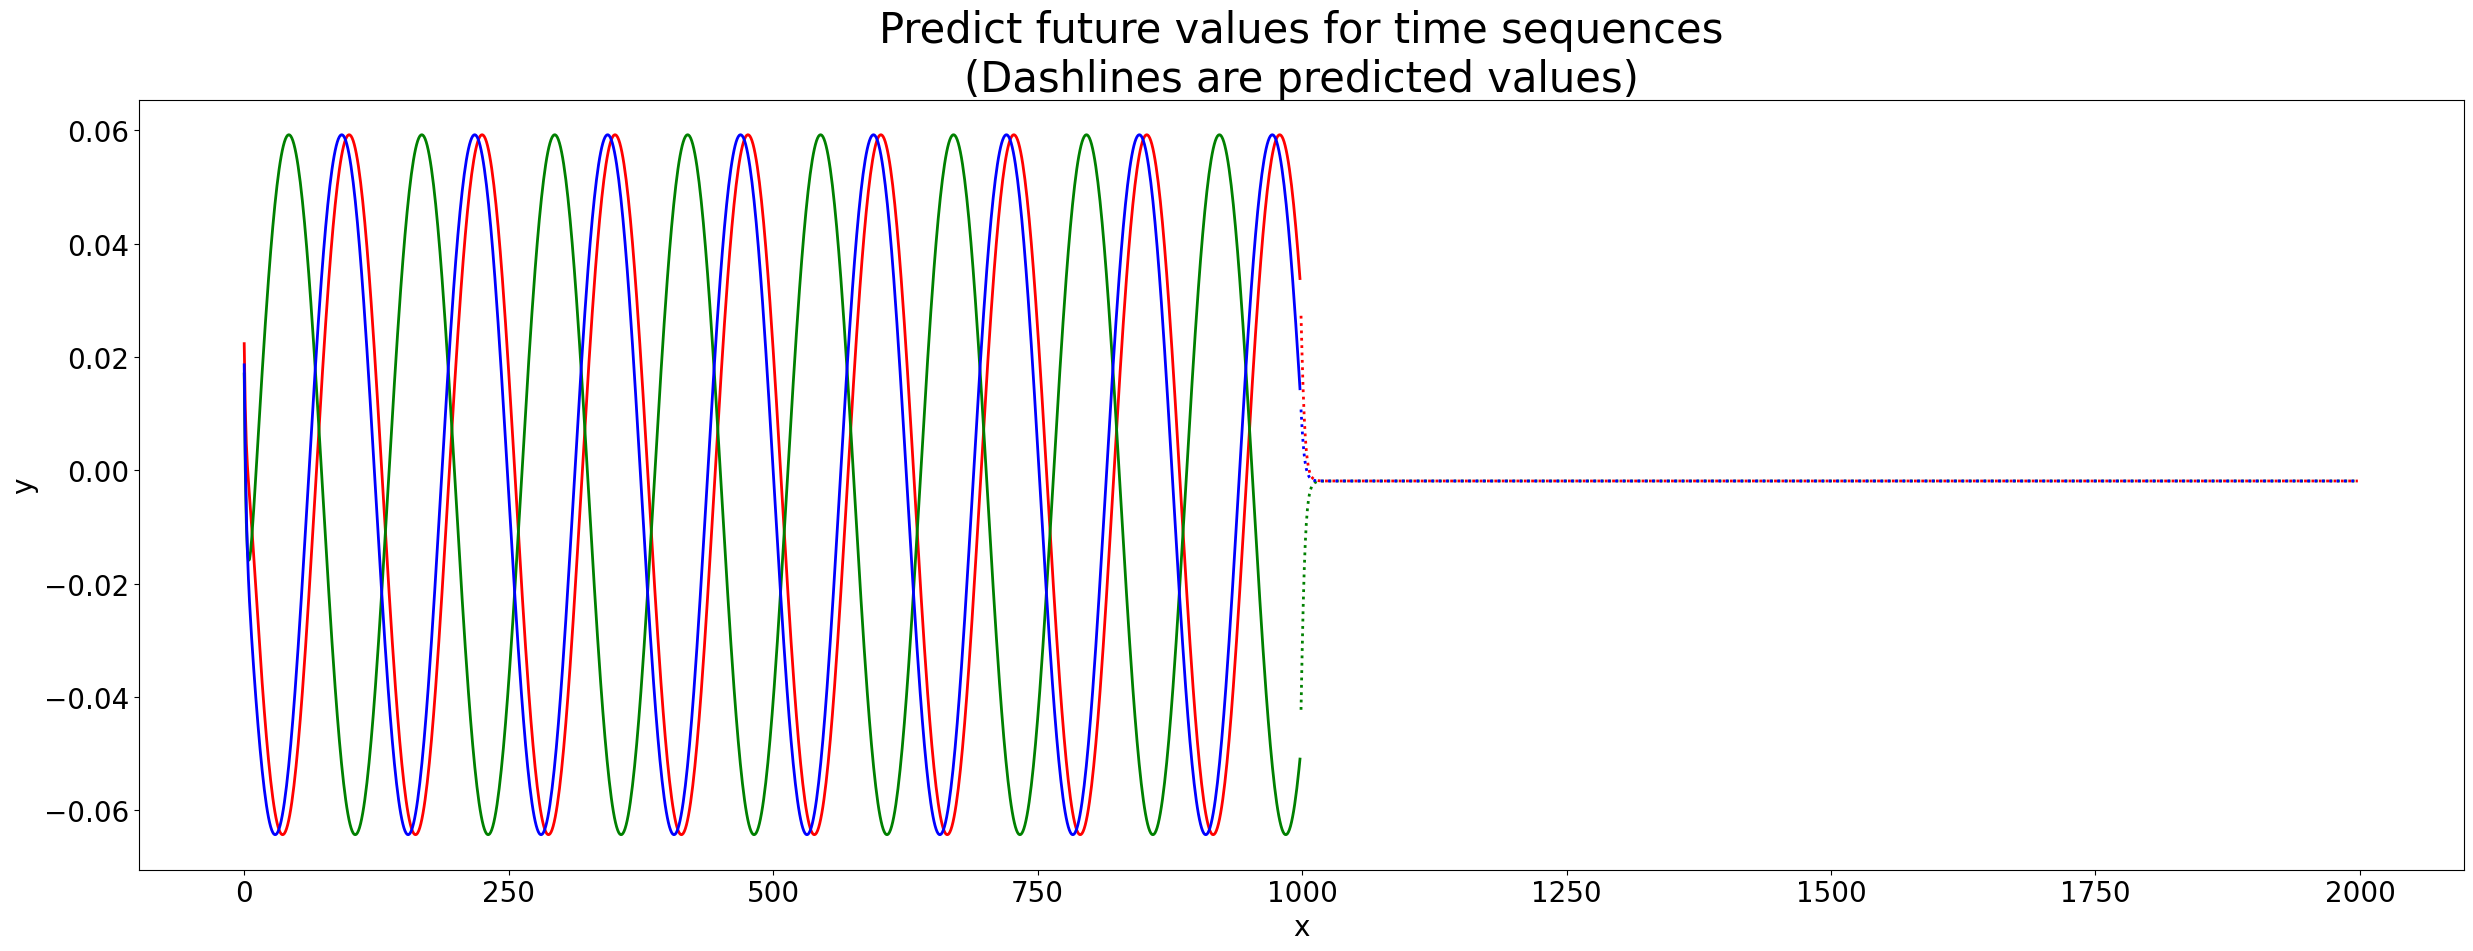

STEP:  6
loss: 0.441269186556893
test loss: 0.4226315985730342


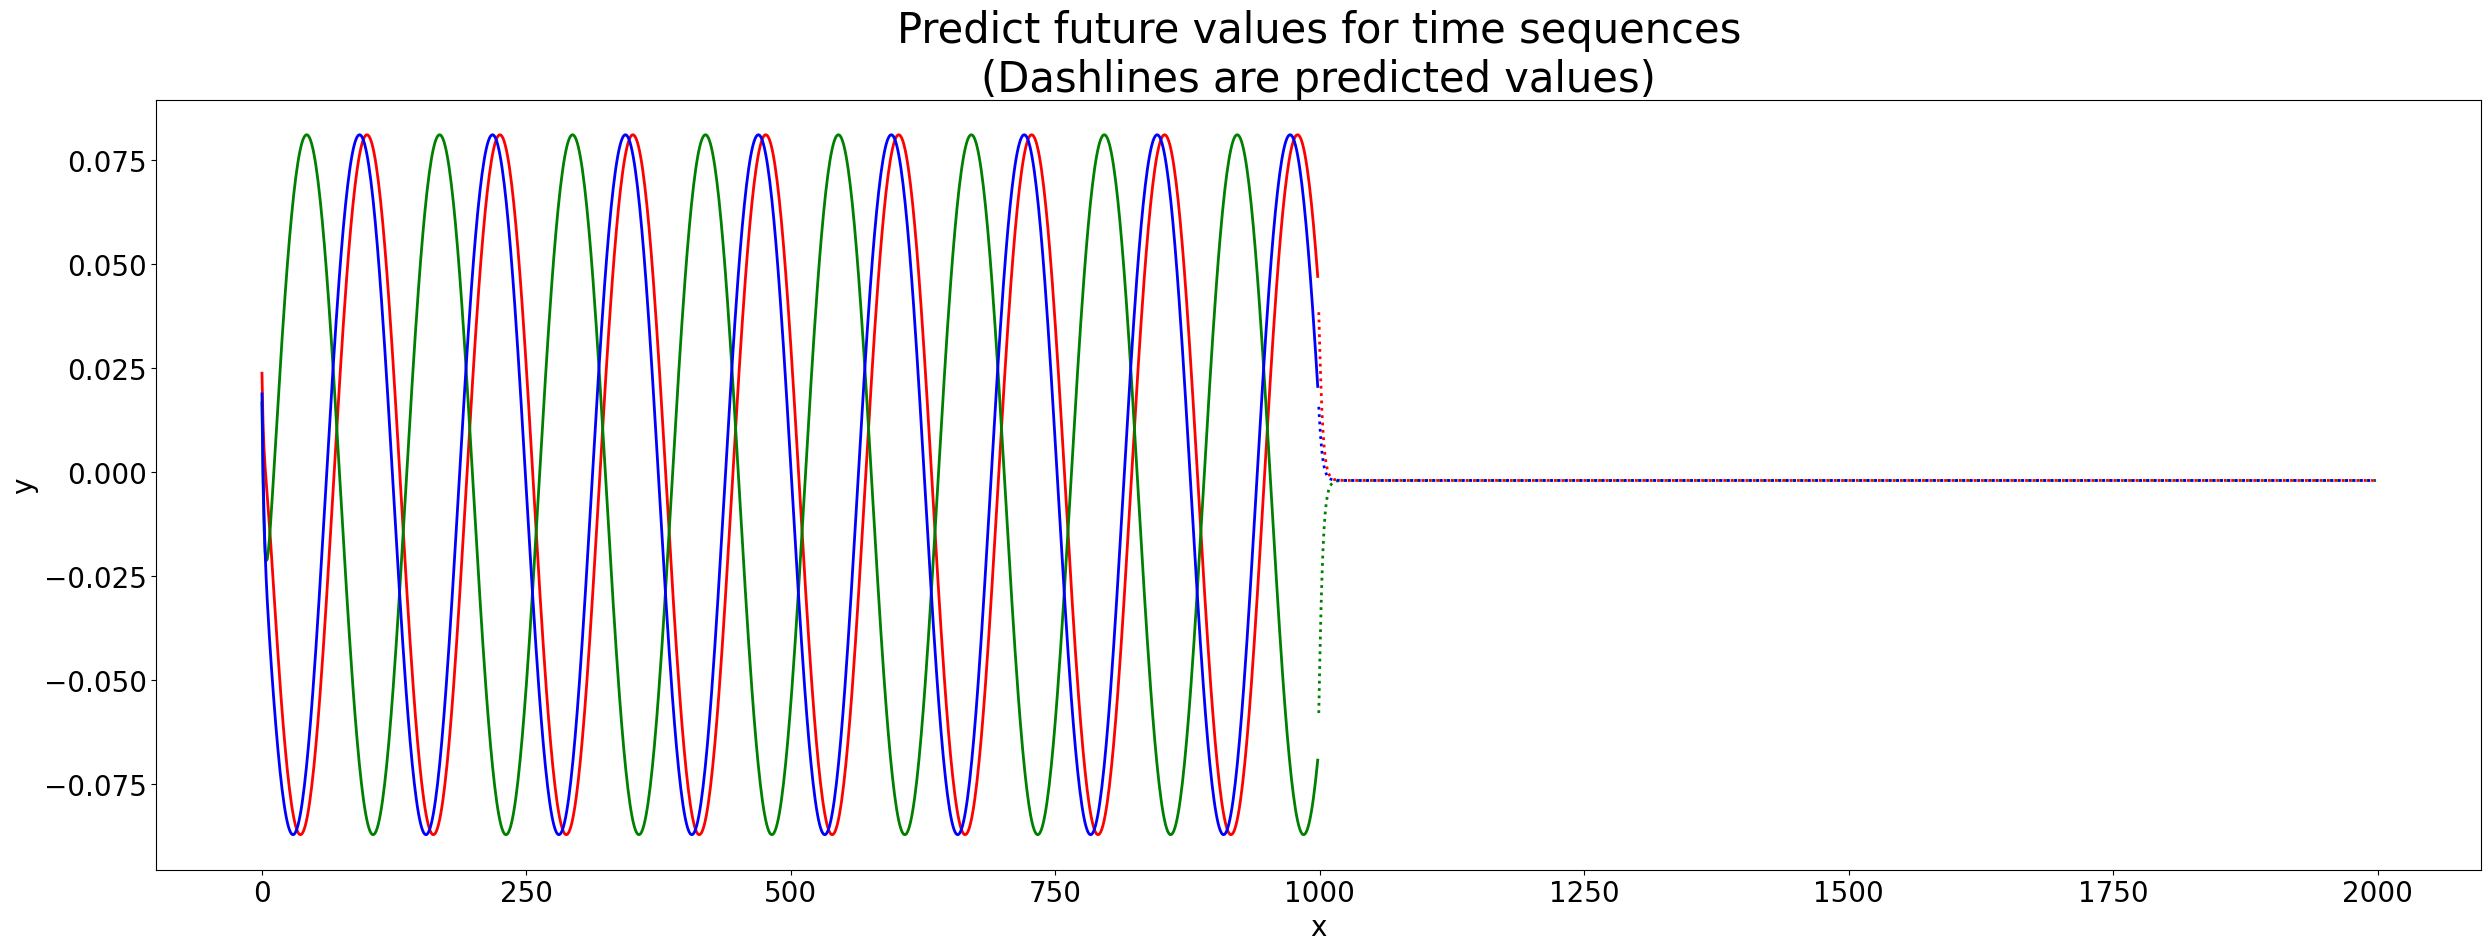

STEP:  7
loss: 0.4208277122038889
test loss: 0.39410408306189604


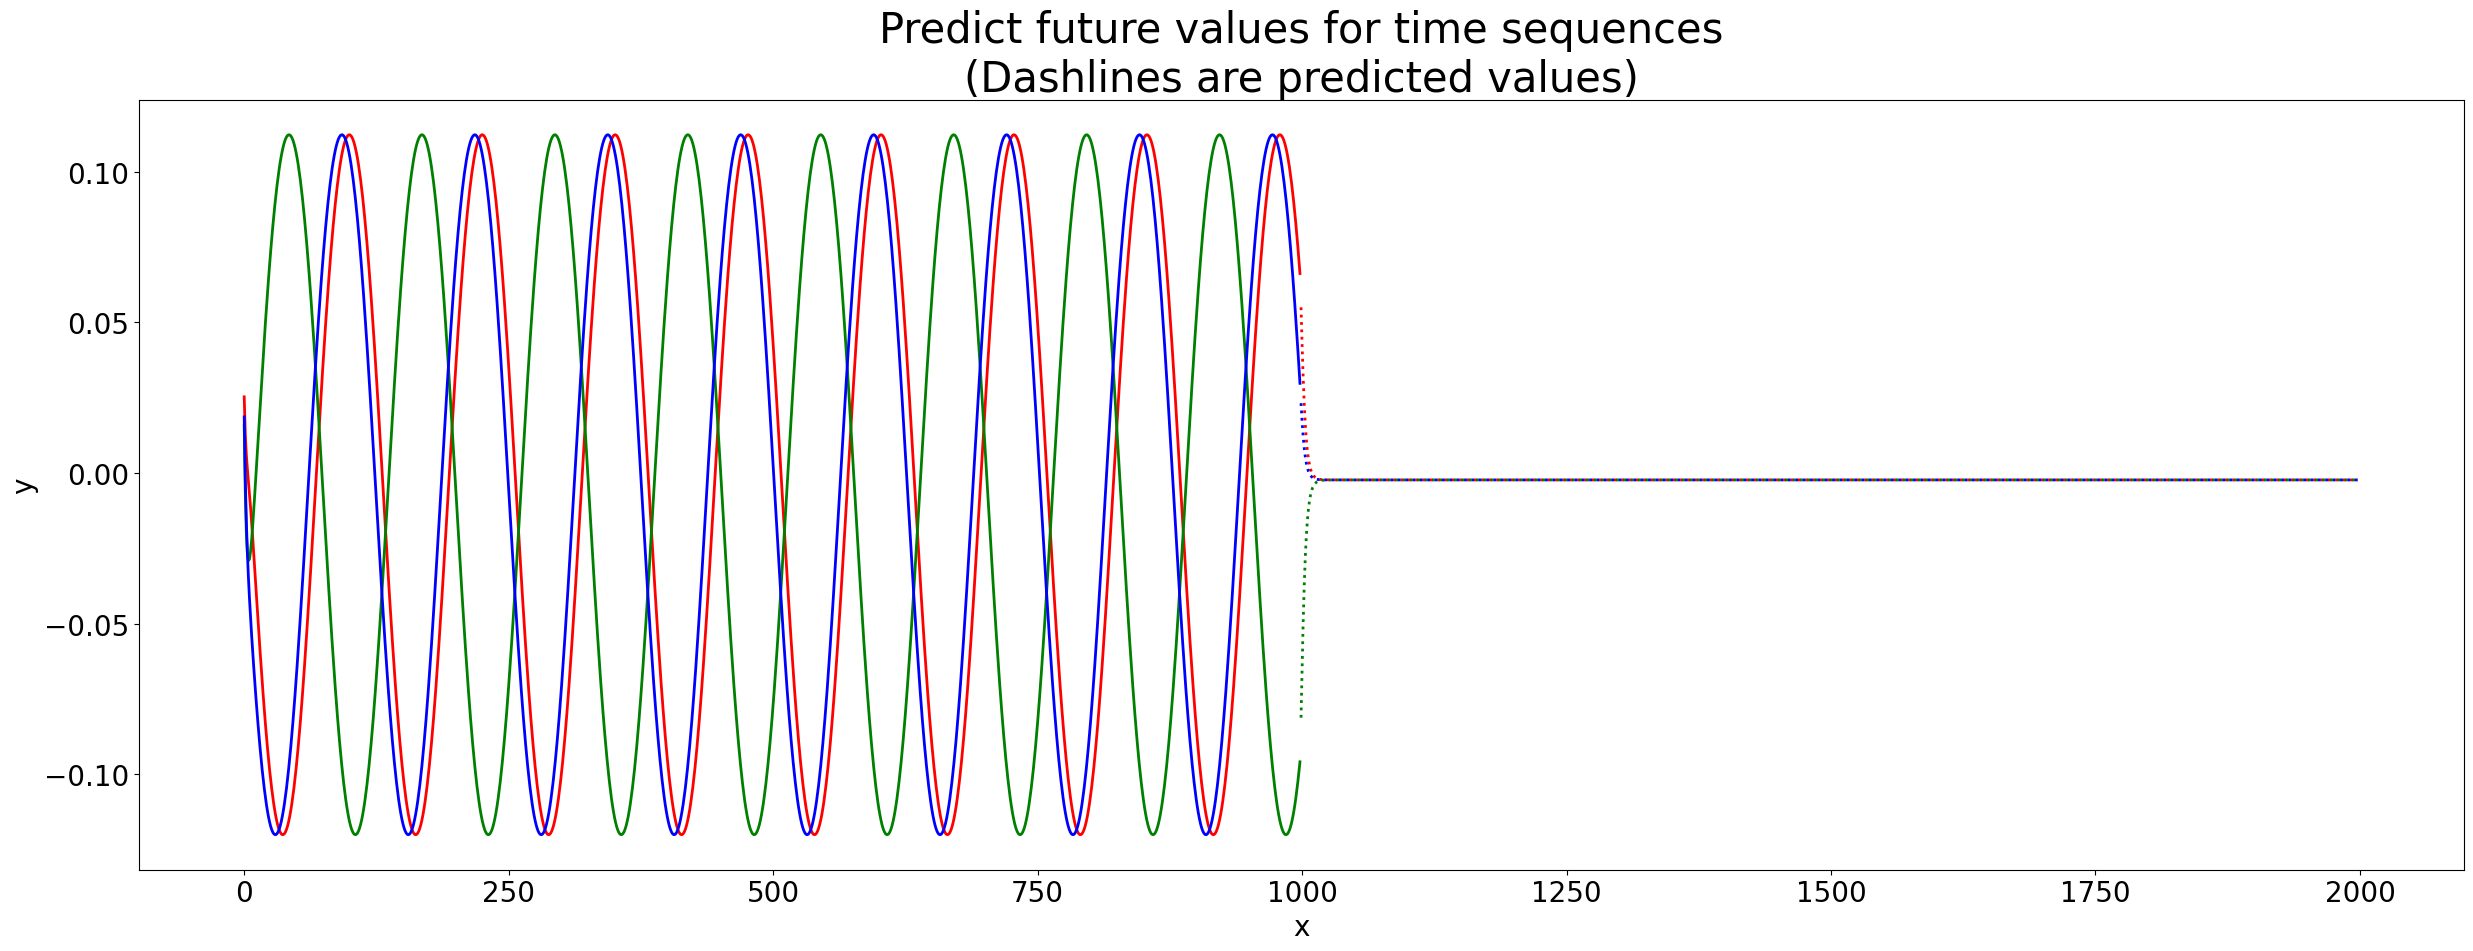

STEP:  8
loss: 0.3924927083777641
test loss: 0.35373032473011856


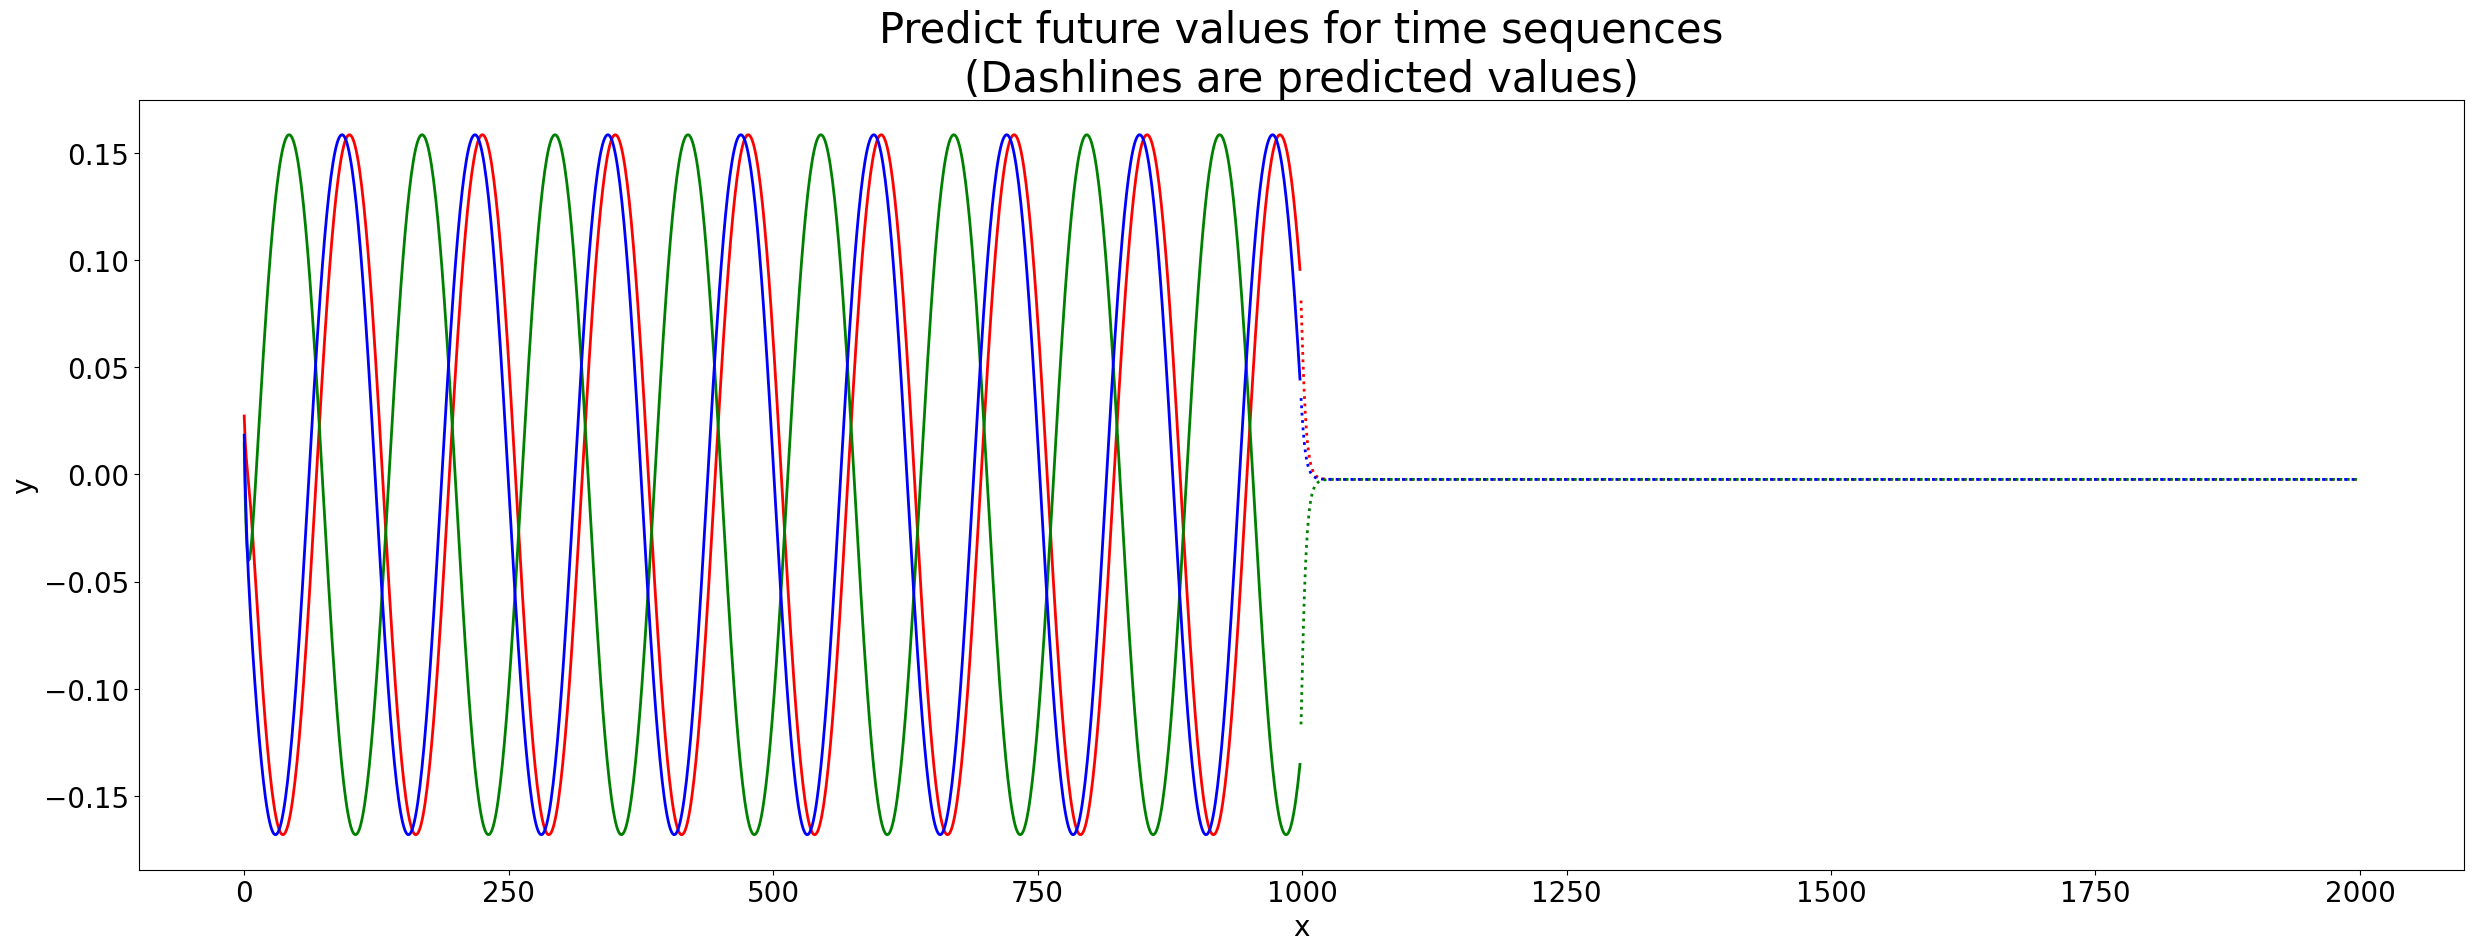

STEP:  9
loss: 0.35239604782311534
test loss: 0.29665749011345677


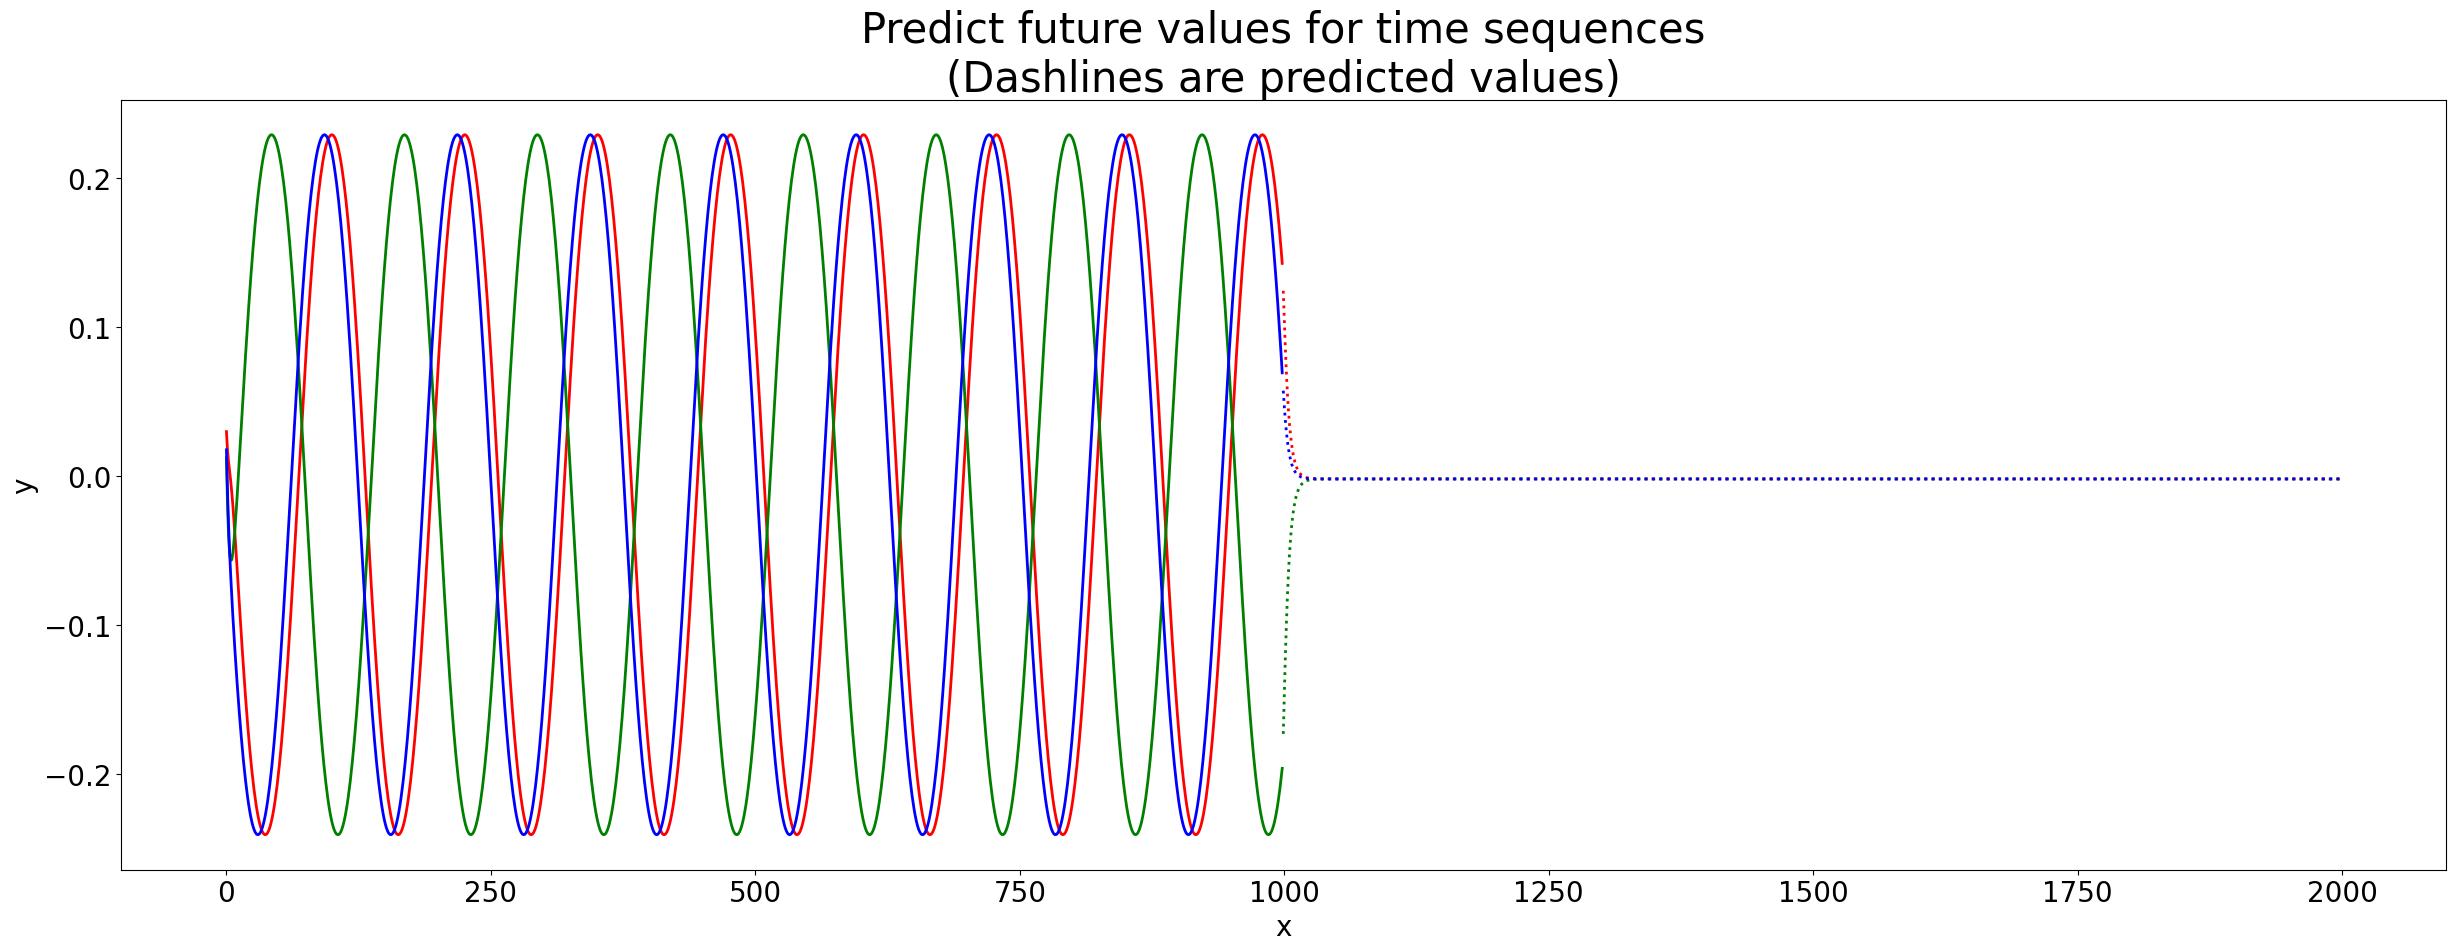

STEP:  10
loss: 0.29572304658845777
test loss: 0.22029765108983143


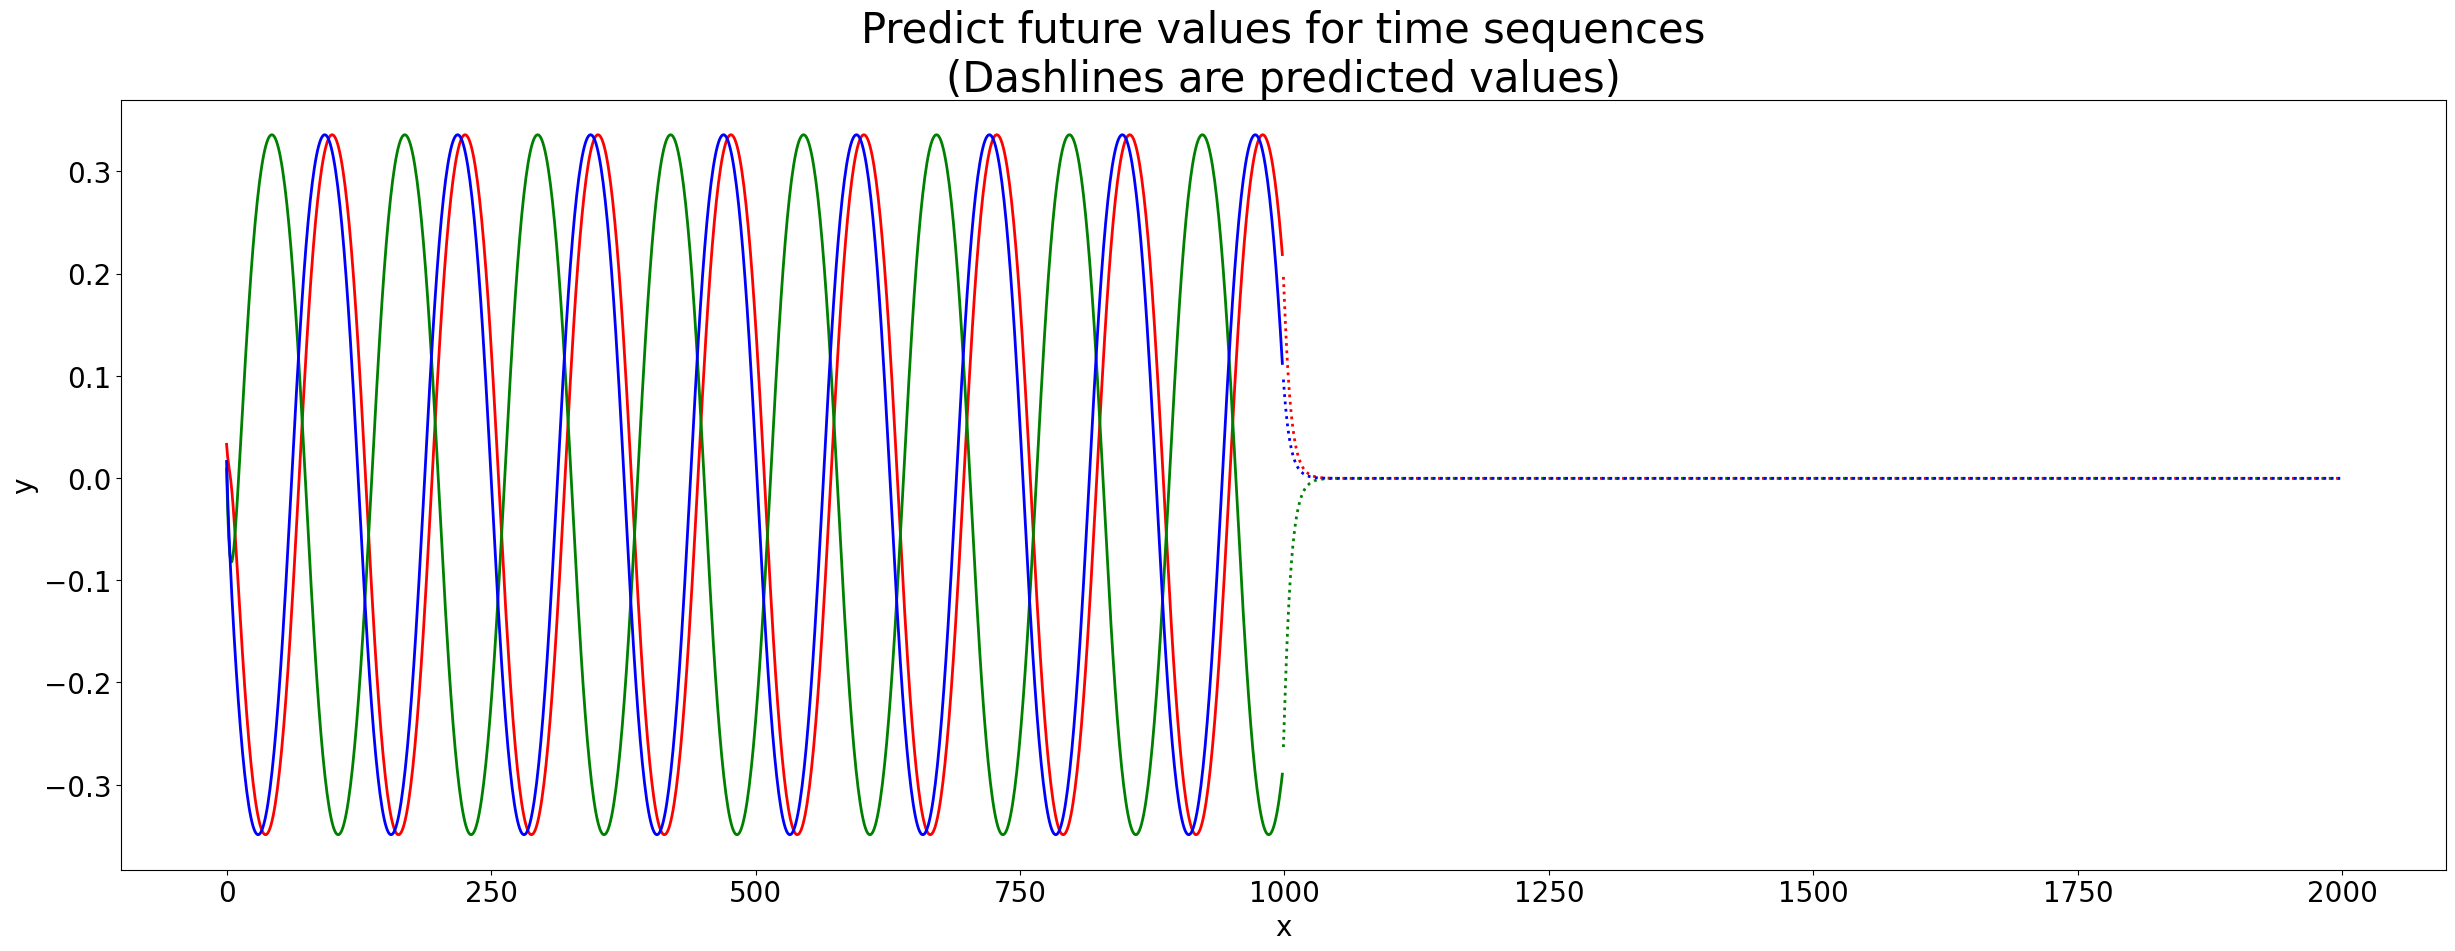

STEP:  11
loss: 0.21991474402982253
test loss: 0.13456416941128757


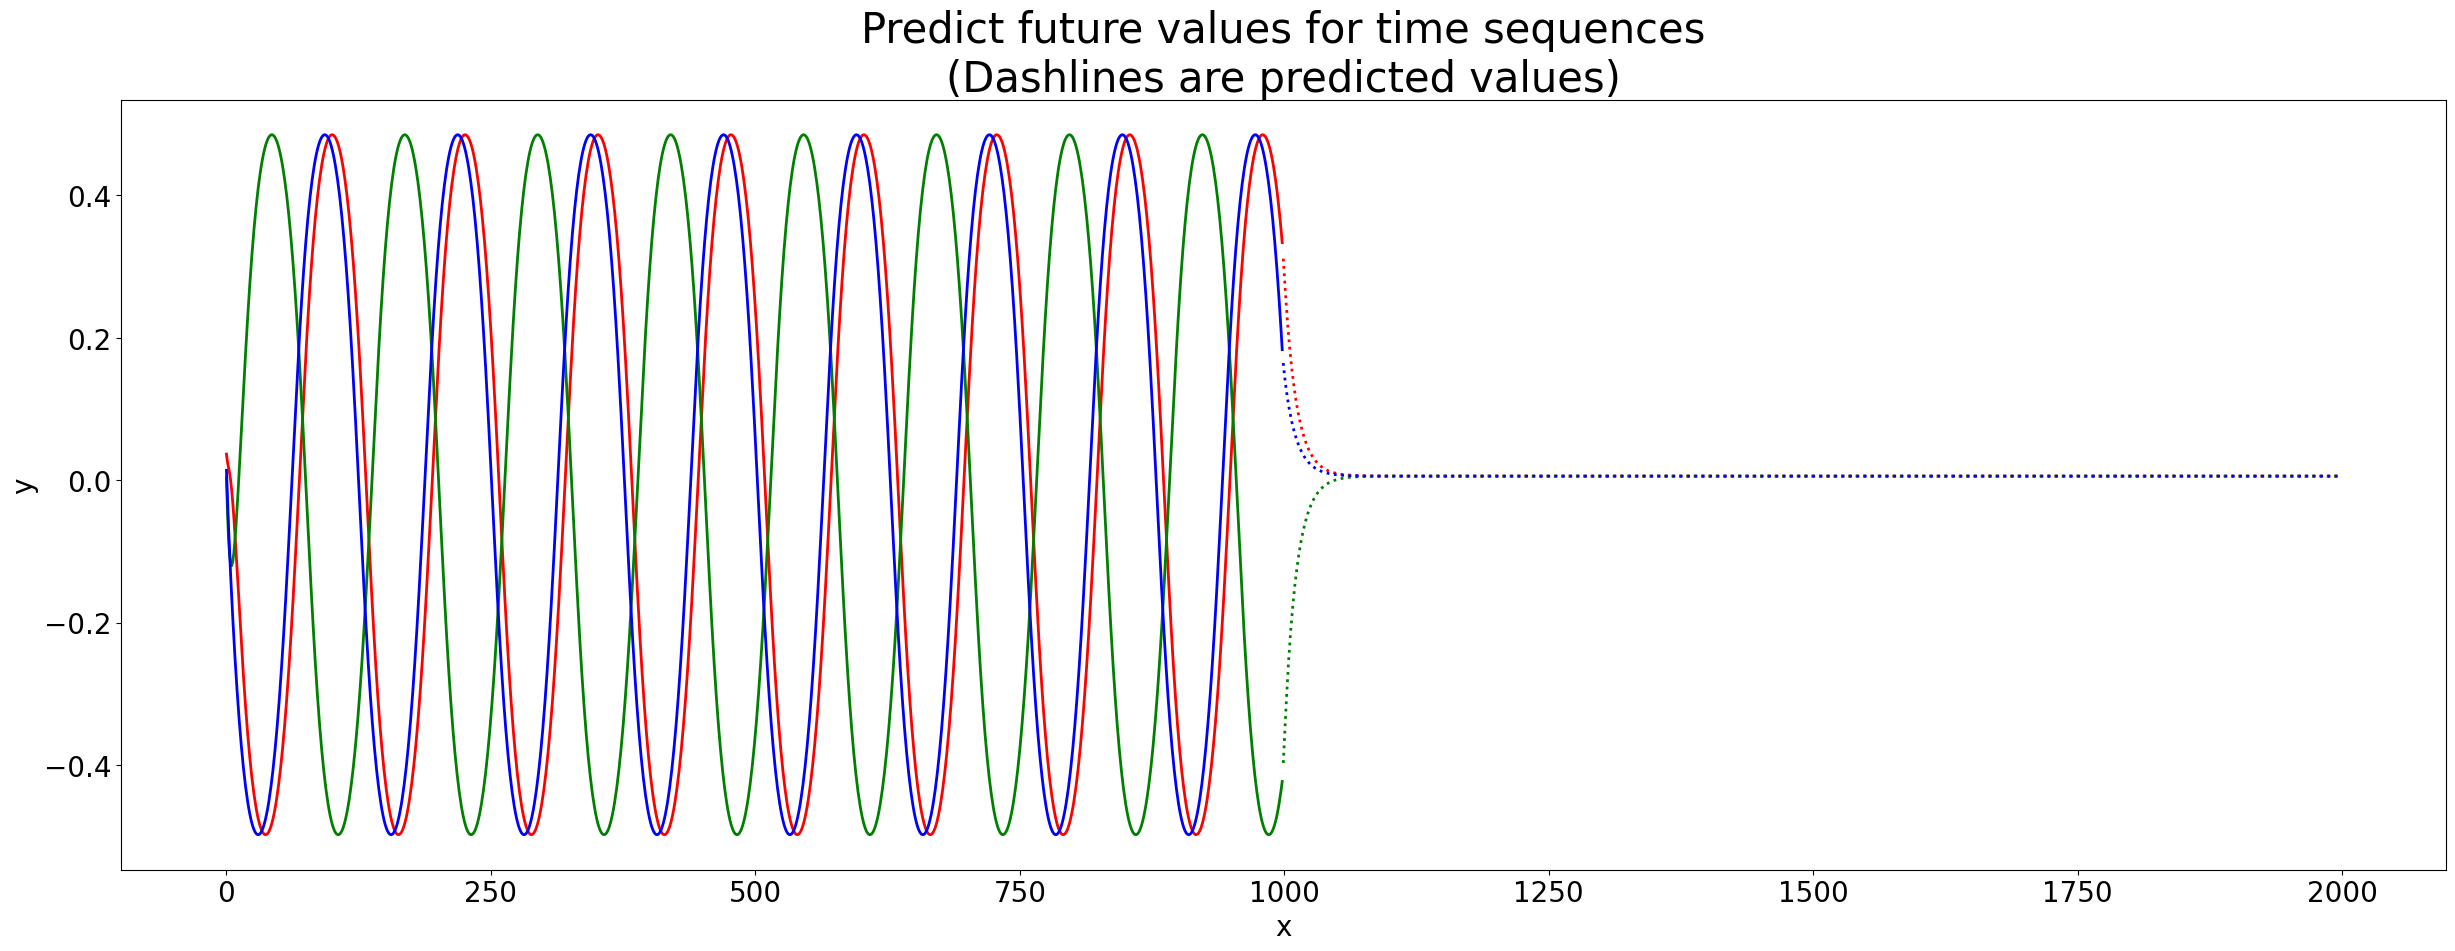

STEP:  12
loss: 0.13484463793902943
test loss: 0.0693813200965689


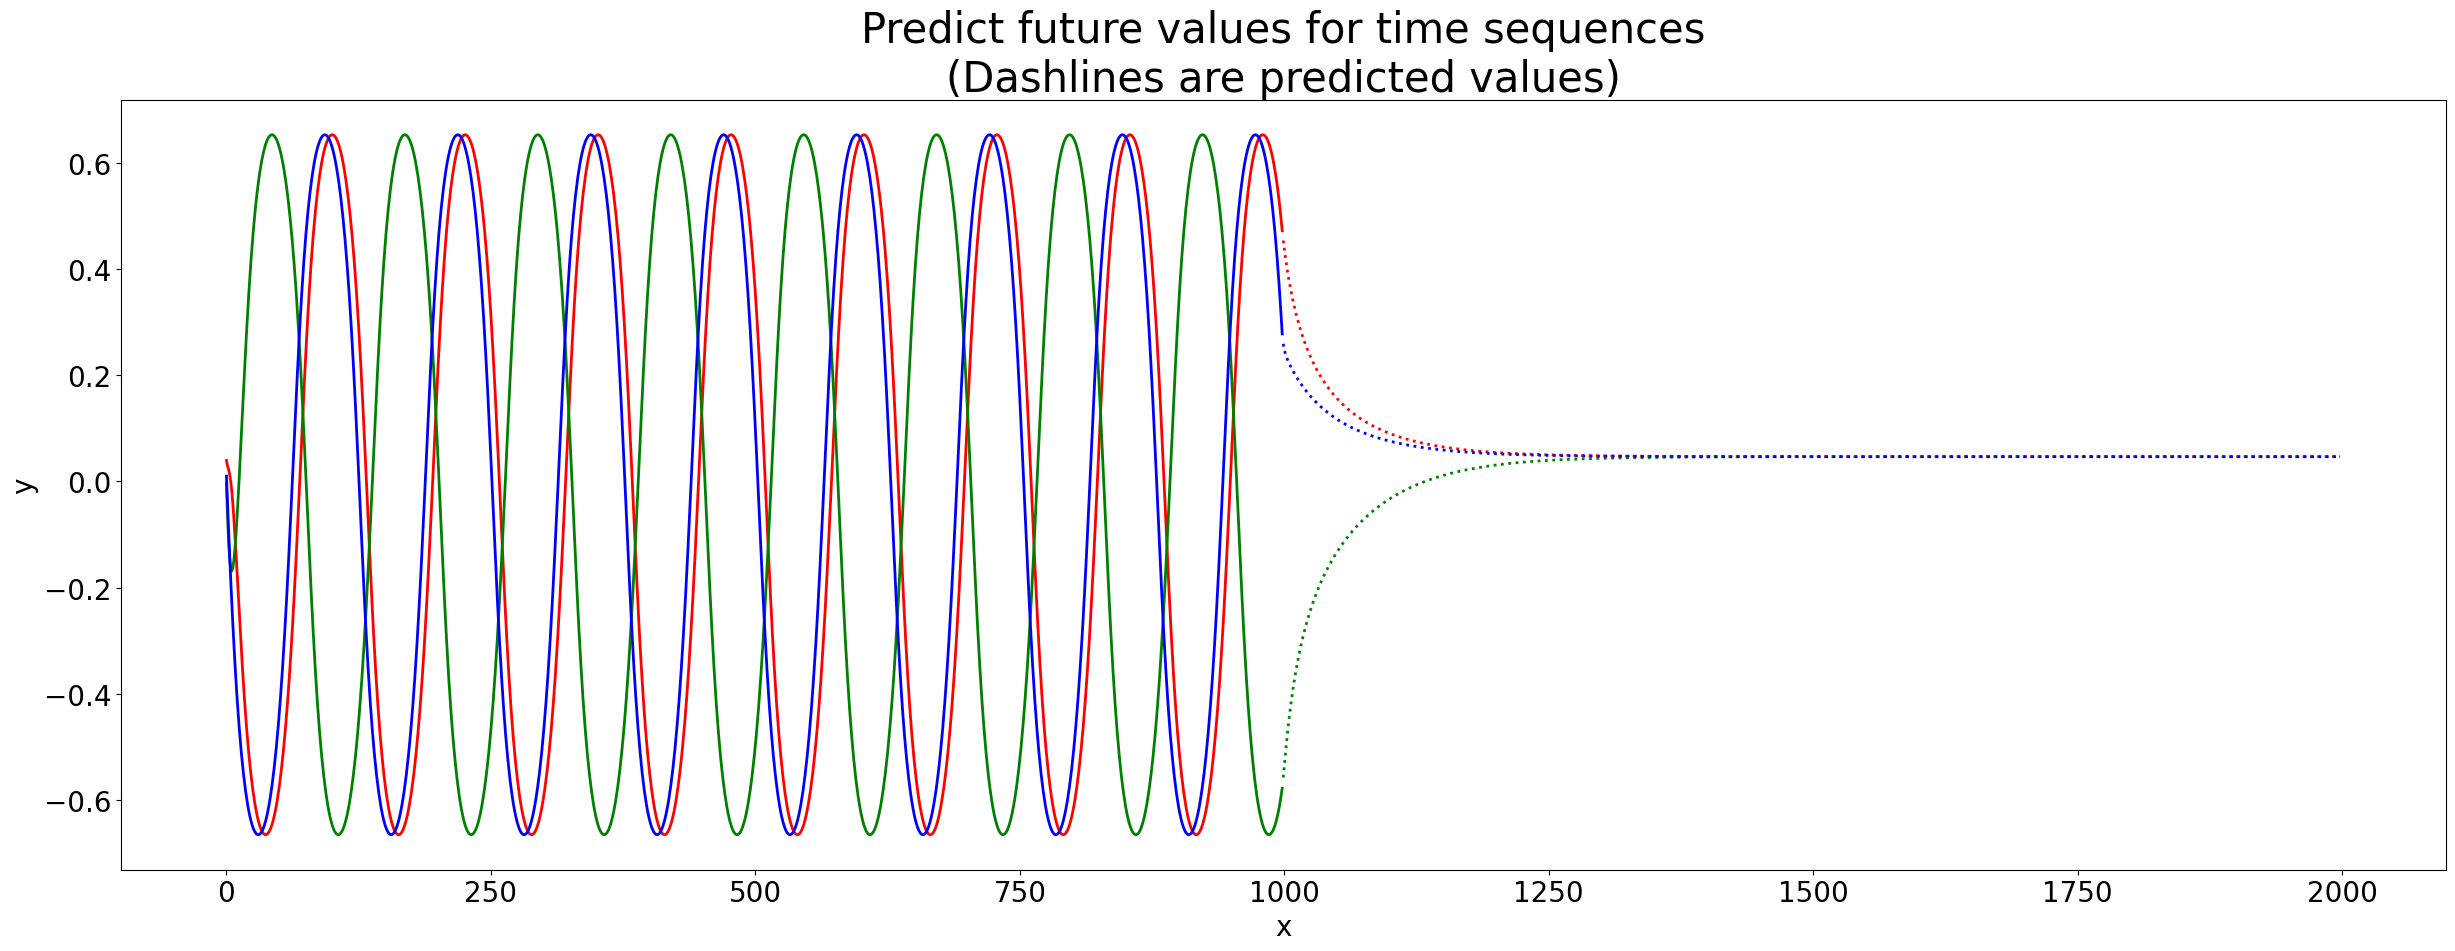

STEP:  13
loss: 0.07027301949153703
test loss: 0.04357218699159126


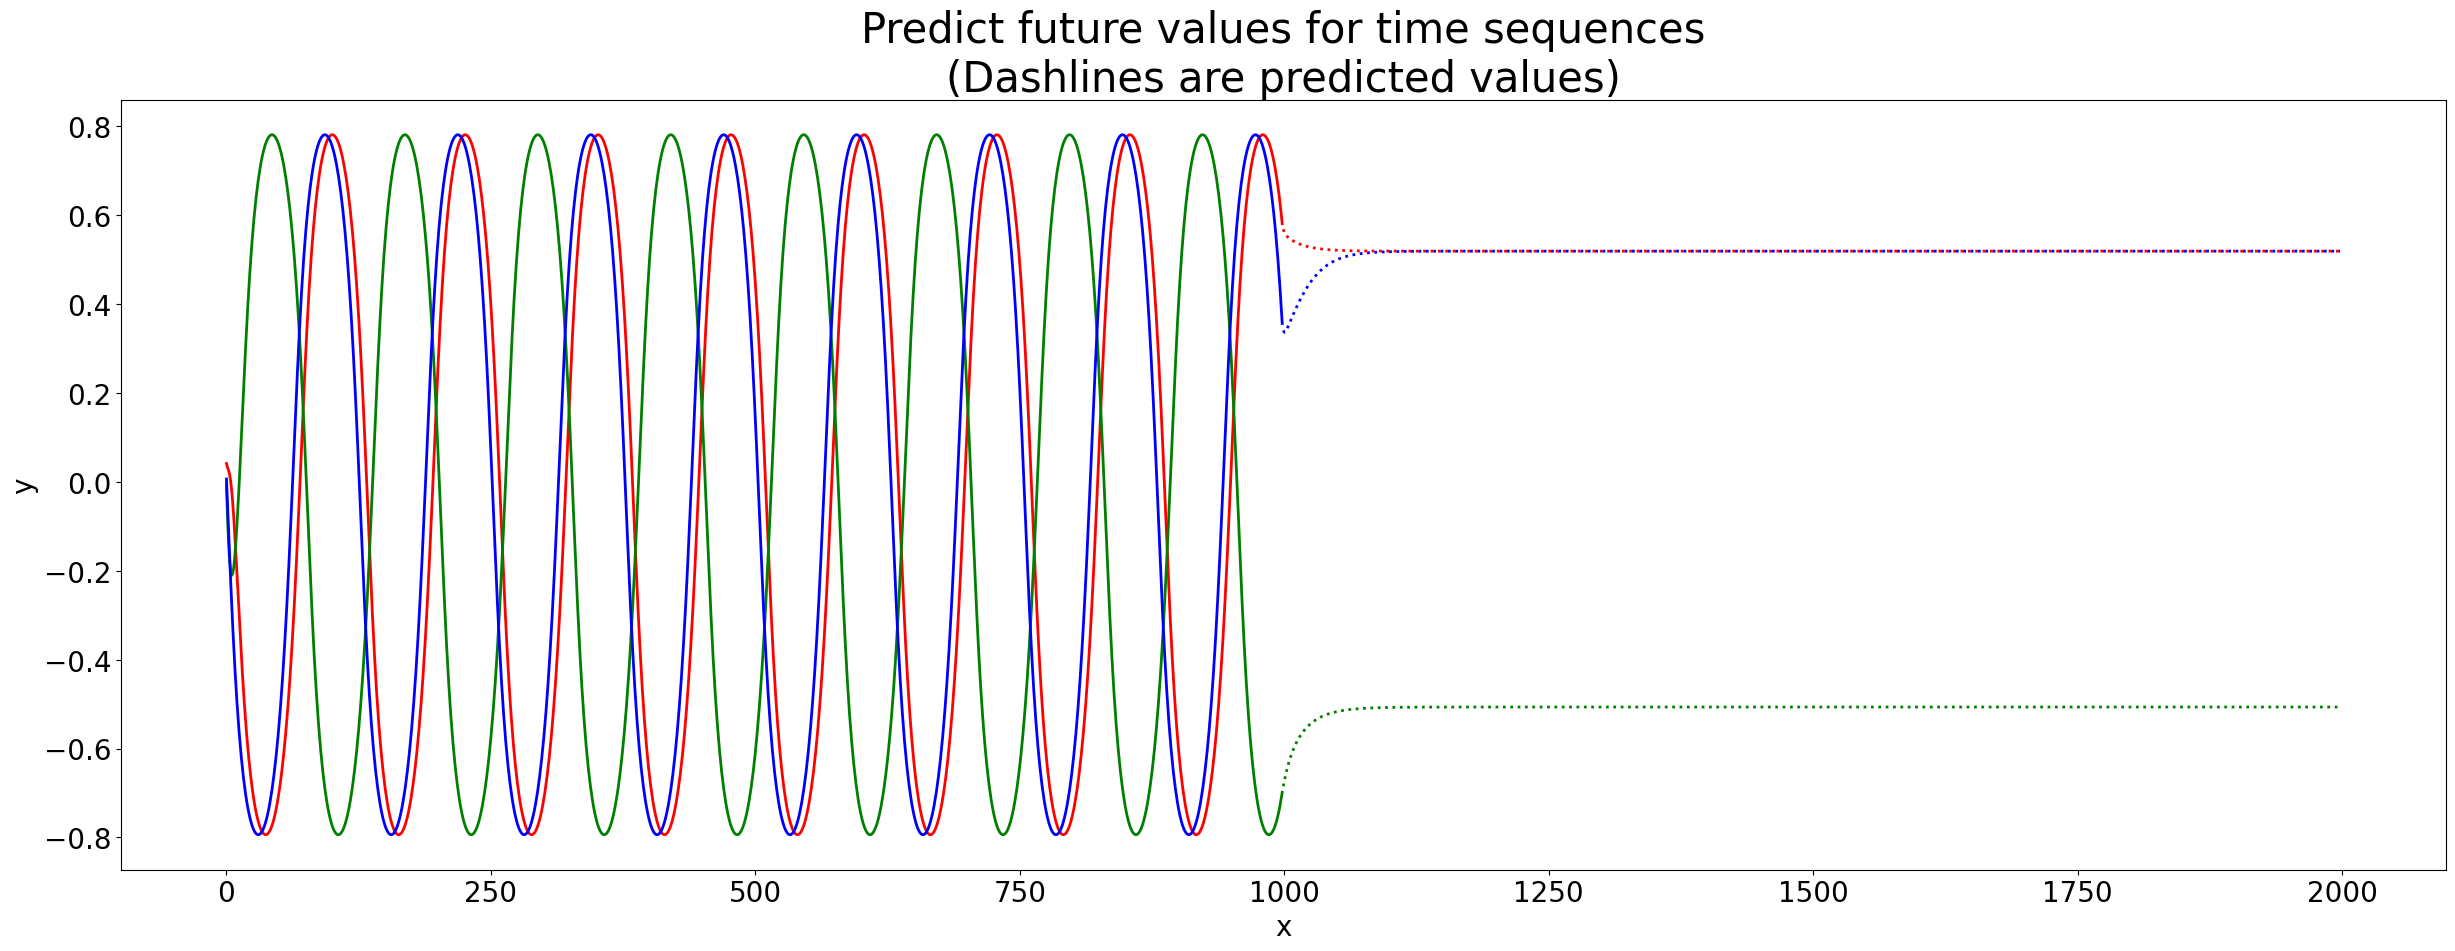

STEP:  14
loss: 0.04483645763548473
test loss: 0.03841911522183094


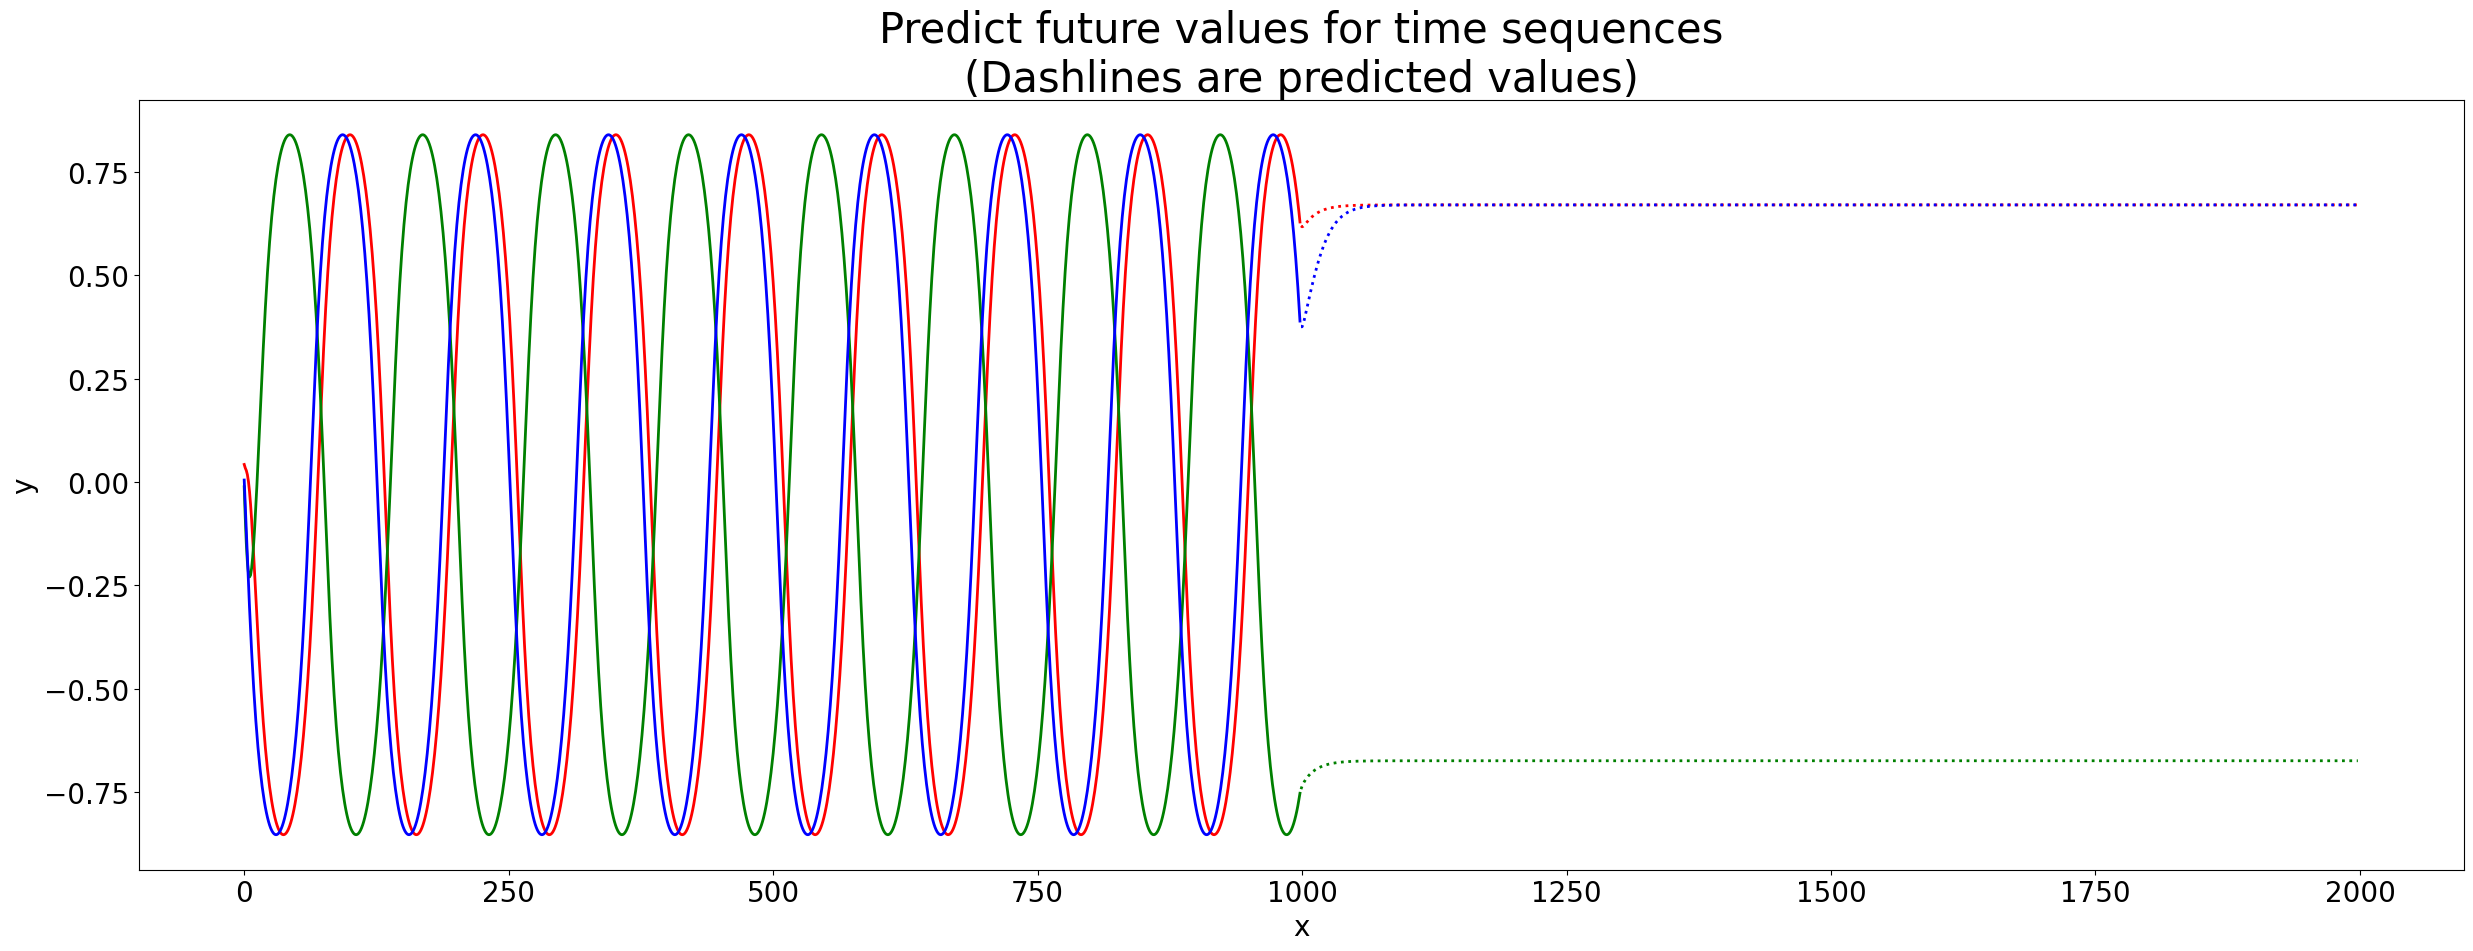

In [11]:
steps = 15
# set random seed to 0
np.random.seed(0)
torch.manual_seed(0)
# load data and make training set
data = torch.load('traindata.pt')
input = torch.from_numpy(data[3:, :-1])
target = torch.from_numpy(data[3:, 1:])
test_input = torch.from_numpy(data[:3, :-1])
test_target = torch.from_numpy(data[:3, 1:])
# build the model
seq = Sequence()
seq.double()
criterion = nn.MSELoss()
# use LBFGS as optimizer since we can load the whole data to train
optimizer = optim.LBFGS(seq.parameters(), lr=0.4)
#begin to train
for i in range(steps):
    print('STEP: ', i)
    def closure():
        optimizer.zero_grad()
        out = seq(input)
        loss = criterion(out, target)
        print('loss:', loss.item())
        loss.backward()
        return loss
    optimizer.step(closure)
    # begin to predict, no need to track gradient here
    with torch.no_grad():
        future = 1000
        pred = seq(test_input, future=future)
        loss = criterion(pred[:, :-future], test_target)
        print('test loss:', loss.item())
        y = pred.detach().numpy()
    # draw the result
    plt.figure(figsize=(30,10))
    plt.title('Predict future values for time sequences\n(Dashlines are predicted values)', fontsize=30)
    plt.xlabel('x', fontsize=20)
    plt.ylabel('y', fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    def draw(yi, color):
        plt.plot(np.arange(input.size(1)), yi[:input.size(1)], color, linewidth = 2.0)
        plt.plot(np.arange(input.size(1), input.size(1) + future), yi[input.size(1):], color + ':', linewidth = 2.0)
    draw(y[0], 'r')
    draw(y[1], 'g')
    draw(y[2], 'b')
    plt.show()
    plt.savefig('predict%d.png'%i)
    plt.close()